<a href="https://colab.research.google.com/github/sunmarknatecom/01_markcv/blob/master/ct_segmentationv_sub2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PET/CT영상에서의 비조영CT 분절화**

* STEP 1 : BODY EXTRACTION

* STEP 2 : L3 VERTEBRAL BODY EXTRACTION

* STEP 3 : ABDOMEN SPACE SEGMENTATION

* STEP 4 : ABDOMINAL MUSCLE, VAT, SAT SEGMENTATION


# **코딩 규칙**

> 문자 인용은 C, C++의 규정을 따른다

> 문자 인용은 '' 를 사용: ex) 'a'

> 문자열 인용은 ""를 사용: ex) "ab"

> 변수명은 문자갯수가 4 조합

# 환경설정: 구글드라이브 연결, 모듈과 패키지 설치

## 구글 드라이브 설치가 안 되었을 경우 실행

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [1]:
!pip install pydicom pynrrd

# DATA PREPROCESSING
from glob import glob
import numpy as np
import pydicom, cv2, os
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
import matplotlib.pyplot as plt
from PIL import Image

# DEEP LEARNING MODULES
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import adam_v2

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model
from skimage.metrics import structural_similarity as ssim

from glob import glob
import cv2
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

     |████████████████████████████████| 2.0 MB 36.1 MB/s 


# 1단계: 데이터 전처리

## CONFIRM THE GPU

In [2]:
train_imgs = np.load("/content/drive/MyDrive/segmentation/train_imgs.npy")
train_msks = np.load("/content/drive/MyDrive/segmentation/train_msks.npy")
valid_imgs = np.load("/content/drive/MyDrive/segmentation/valid_imgs.npy")
valid_msks = np.load("/content/drive/MyDrive/segmentation/valid_msks.npy")

In [3]:
print("Images number for training   : ", np.shape(train_imgs))
print("Masks number for training    : ", np.shape(train_msks))
print("Images number for validation : ", np.shape(valid_imgs))
print("Masks number for validation  : ", np.shape(valid_msks))

Images number for training   :  (1800, 512, 512)
Masks number for training    :  (1800, 512, 512)
Images number for validation :  (428, 512, 512)
Masks number for validation  :  (428, 512, 512)


In [4]:
train_msks = train_msks.astype(np.float32)
train_msks = np.reshape(train_msks, (*train_msks.shape, 1))

valid_msks = valid_msks.astype(np.float32)
valid_msks = np.reshape(valid_msks, (*valid_msks.shape, 1))

In [5]:
!nvidia-smi

Thu May 12 13:42:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError("GPU device not found")
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


## CREATE THE TRAIN DATA AND LABELS

In [ ]:
del train_imgs, train_msks

In [ ]:
train_imgs = []
window_center = -450
window_width = 1500

from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut

def img_norm(path_d):
    obj = pydicom.dcmread(path_d)
    temp_arr = obj.pixel_array
    s = int(obj.RescaleSlope)
    b = int(obj.RescaleIntercept)
    temp_arr = s * temp_arr + b
    obj.WindowCenter = window_center
    obj.WindowWidth = window_width
    arr = apply_voi_lut(temp_arr, obj)
    Max_val = np.max(arr)
    Min_val = np.min(arr)
    Up_arr = arr - Min_val
    Dn_arr = Max_val - Min_val
    nor_arr = Up_arr / Dn_arr
    del obj, temp_arr, arr, Up_arr
    return nor_arr

for path in train_imgs_path:
    ret_arr = img_norm(path)
    train_imgs.append(ret_arr)
    del ret_arr

train_imgs = np.array(train_imgs)


train_msks = []

for path in train_msks_path:
    temp_obj = Image.open(path)
    temp_arr = np.array(temp_obj, dtype="uint8")
    train_msks.append(temp_arr)
    del temp_obj

train_msks = np.array(train_msks, dtype="uint8")

In [ ]:
valid_imgs = []
for path in valid_imgs_path:
    ret_arr = img_norm(path)
    valid_imgs.append(ret_arr)
    del ret_arr
valid_imgs = np.array(valid_imgs)
valid_msks = []
for path in valid_msks_path:
    temp_obj = Image.open(path)
    temp_arr = np.array(temp_obj,dtype="uint8")
    valid_msks.append(temp_arr)
    del temp_obj
valid_msks = np.array(valid_msks, dtype="uint8")

In [ ]:
np.save("/content/drive/MyDrive/segmentation/train_imgs", train_imgs)
np.save("/content/drive/MyDrive/segmentation/train_msks", train_msks)
np.save("/content/drive/MyDrive/segmentation/valid_imgs", valid_imgs)
np.save("/content/drive/MyDrive/segmentation/valid_imgs", valid_imgs)

In [ ]:
np.save("/content/drive/MyDrive/segmentation/valid_imgs", valid_imgs)
np.save("/content/drive/MyDrive/segmentation/valid_msks", valid_msks)

In [ ]:
train_msks = train_msks.astype(np.float32)
train_msks = np.reshape(train_msks, (*train_msks.shape, 1))

In [ ]:
valid_msks = valid_msks.astype(np.float32)
valid_msks = np.reshape(valid_msks, (*valid_msks.shape, 1))

In [ ]:
# import numpy as np

# a = np.load('/content/drive/MyDrive/segmentation/data/train_imgs_comp.npz')
# b = np.load('/content/drive/MyDrive/segmentation/data/train_msks_comp.npz')

# a.files
# train_imgs = a['train_imgs']
# b.files
# train_msks = b['a']

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_msks))
test_dataset = tf.data.Dataset.from_tensor_slices((valid_imgs, valid_msks))

## CONFIRM THE TRAIN DATA ND LABELS

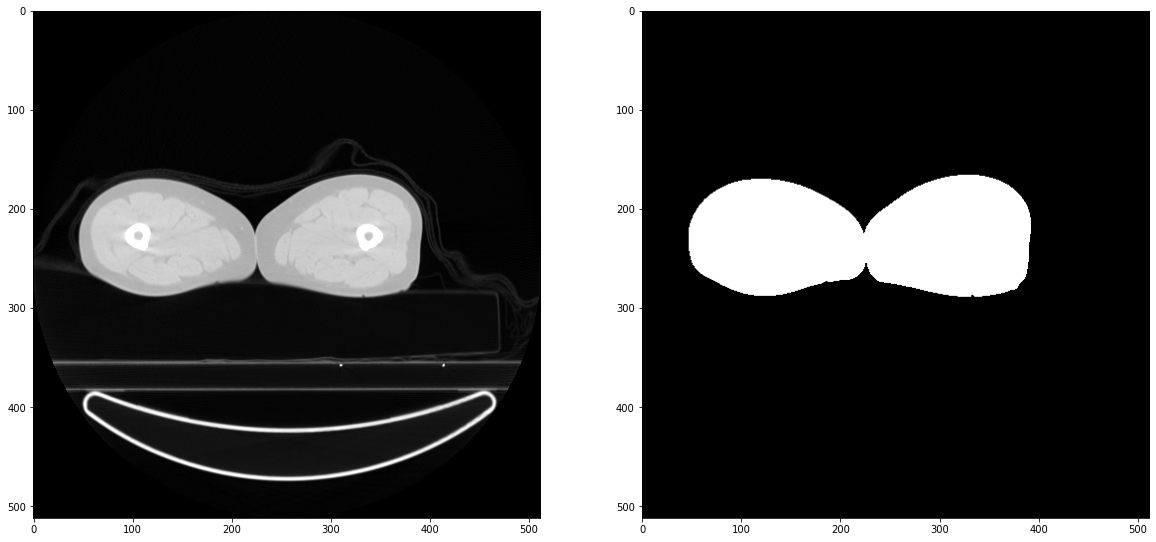

In [7]:
%matplotlib inline

fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[1300], cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_msks[1300]), cmap='gray')

# 2단계: 딥러닝(Tensorflow)

## CONSTRUCT THE MODEL (U_NET)

In [ ]:
del model

In [8]:
inputs = Input((512, 512, 1))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['batch_normalization[0][0]']    
                                )                                                             

## CUSTOM OBJECTS

In [10]:
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1


class Semantic_loss_functions(object):
    def __init__(self):
        print ("semantic loss functions initialized")

    def dice_coef(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

    def sensitivity(self, y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

    def specificity(self, y_true, y_pred):
        true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
        return true_negatives / (possible_negatives + K.epsilon())

    def convert_to_logits(self, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        return tf.math.log(y_pred / (1 - y_pred))

    def weighted_cross_entropyloss(self, y_true, y_pred):
        y_pred = self.convert_to_logits(y_pred)
        pos_weight = beta / (1 - beta)
        loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=pos_weight)
        return tf.reduce_mean(loss)

    def focal_loss_with_logits(self, logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    def focal_loss(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        logits = tf.math.log(y_pred / (1 - y_pred))
        loss = self.focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
        return tf.reduce_mean(loss)

    def depth_softmax(self, matrix):
        sigmoid = lambda x: 1 / (1 + K.exp(-x))
        sigmoided_matrix = sigmoid(matrix)
        softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=0)
        return softmax_matrix

    def generalized_dice_coefficient(self, y_true, y_pred):
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return score

    def dice_loss(self, y_true, y_pred):
        loss = 1 - self.generalized_dice_coefficient(y_true, y_pred)
        return loss

    def bce_dice_loss(self, y_true, y_pred):
        loss = binary_crossentropy(y_true, y_pred) + self.dice_loss(y_true, y_pred)
        return loss / 2.0

    def confusion(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.clip(y_pred, 0, 1)
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.clip(y_true, 0, 1)
        y_neg = 1 - y_pos
        tp = K.sum(y_pos * y_pred_pos)
        fp = K.sum(y_neg * y_pred_pos)
        fn = K.sum(y_pos * y_pred_neg)
        prec = (tp + smooth) / (tp + fp + smooth)
        recall = (tp + smooth) / (tp + fn + smooth)
        return prec, recall

    def true_positive(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pos = K.round(K.clip(y_true, 0, 1))
        tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
        return tp

    def true_negative(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
        return tn

    def tversky_index(self, y_true, y_pred):
        y_true_pos = K.flatten(y_true)
        y_pred_pos = K.flatten(y_pred)
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
        alpha = 0.7
        return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

    def tversky_loss(self, y_true, y_pred):
        return 1 - self.tversky_index(y_true, y_pred)

    def focal_tversky(self, y_true, y_pred):
        pt_1 = self.tversky_index(y_true, y_pred)
        gamma = 0.75
        return K.pow((1 - pt_1), gamma)

    def log_cosh_dice_loss(self, y_true, y_pred):
        x = self.dice_loss(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

In [11]:
# Reference
# https://www.sciencedirect.com/science/article/pii/S2665963821000269
# https://github.com/SoftwareImpacts/SIMPAC-2021-46

import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy
import keras

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss / 2.0

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="mymodel_{epoch}.h5",save_best_only=True,monitor='val_loss',verbose=1)]

## COMPILE

In [ ]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

In [12]:
model.compile(adam_v2.Adam(learning_rate=1e-4), bce_dice_loss, metrics=[binary_crossentropy, generalized_dice_coefficient])

## TRAIN(FIT)

In [13]:
model.fit(train_imgs, train_msks, batch_size=10, epochs=20, validation_data=(valid_imgs, valid_msks))

Epoch 1/20
180/180 [==============================] - 172s 840ms/step - loss: 0.1779 - binary_crossentropy: 0.1826 - generalized_dice_coefficient: 0.8267 - val_loss: 0.0725 - val_binary_crossentropy: 0.0661 - val_generalized_dice_coefficient: 0.9211
Epoch 2/20
180/180 [==============================] - 154s 854ms/step - loss: 0.0273 - binary_crossentropy: 0.0327 - generalized_dice_coefficient: 0.9781 - val_loss: 0.0201 - val_binary_crossentropy: 0.0180 - val_generalized_dice_coefficient: 0.9778
Epoch 3/20
180/180 [==============================] - 157s 870ms/step - loss: 0.0226 - binary_crossentropy: 0.0276 - generalized_dice_coefficient: 0.9823 - val_loss: 0.0166 - val_binary_crossentropy: 0.0172 - val_generalized_dice_coefficient: 0.9840
Epoch 4/20
180/180 [==============================] - 157s 872ms/step - loss: 0.0196 - binary_crossentropy: 0.0244 - generalized_dice_coefficient: 0.9852 - val_loss: 0.0112 - val_binary_crossentropy: 0.0104 - val_generalized_dice_coefficient: 0.9881


## SAVE THE TRAINED MODEL

In [14]:
model.save("/content/drive/MyDrive/segmentation/storage_data/my_model_4.h5")

## MODEL VIEW

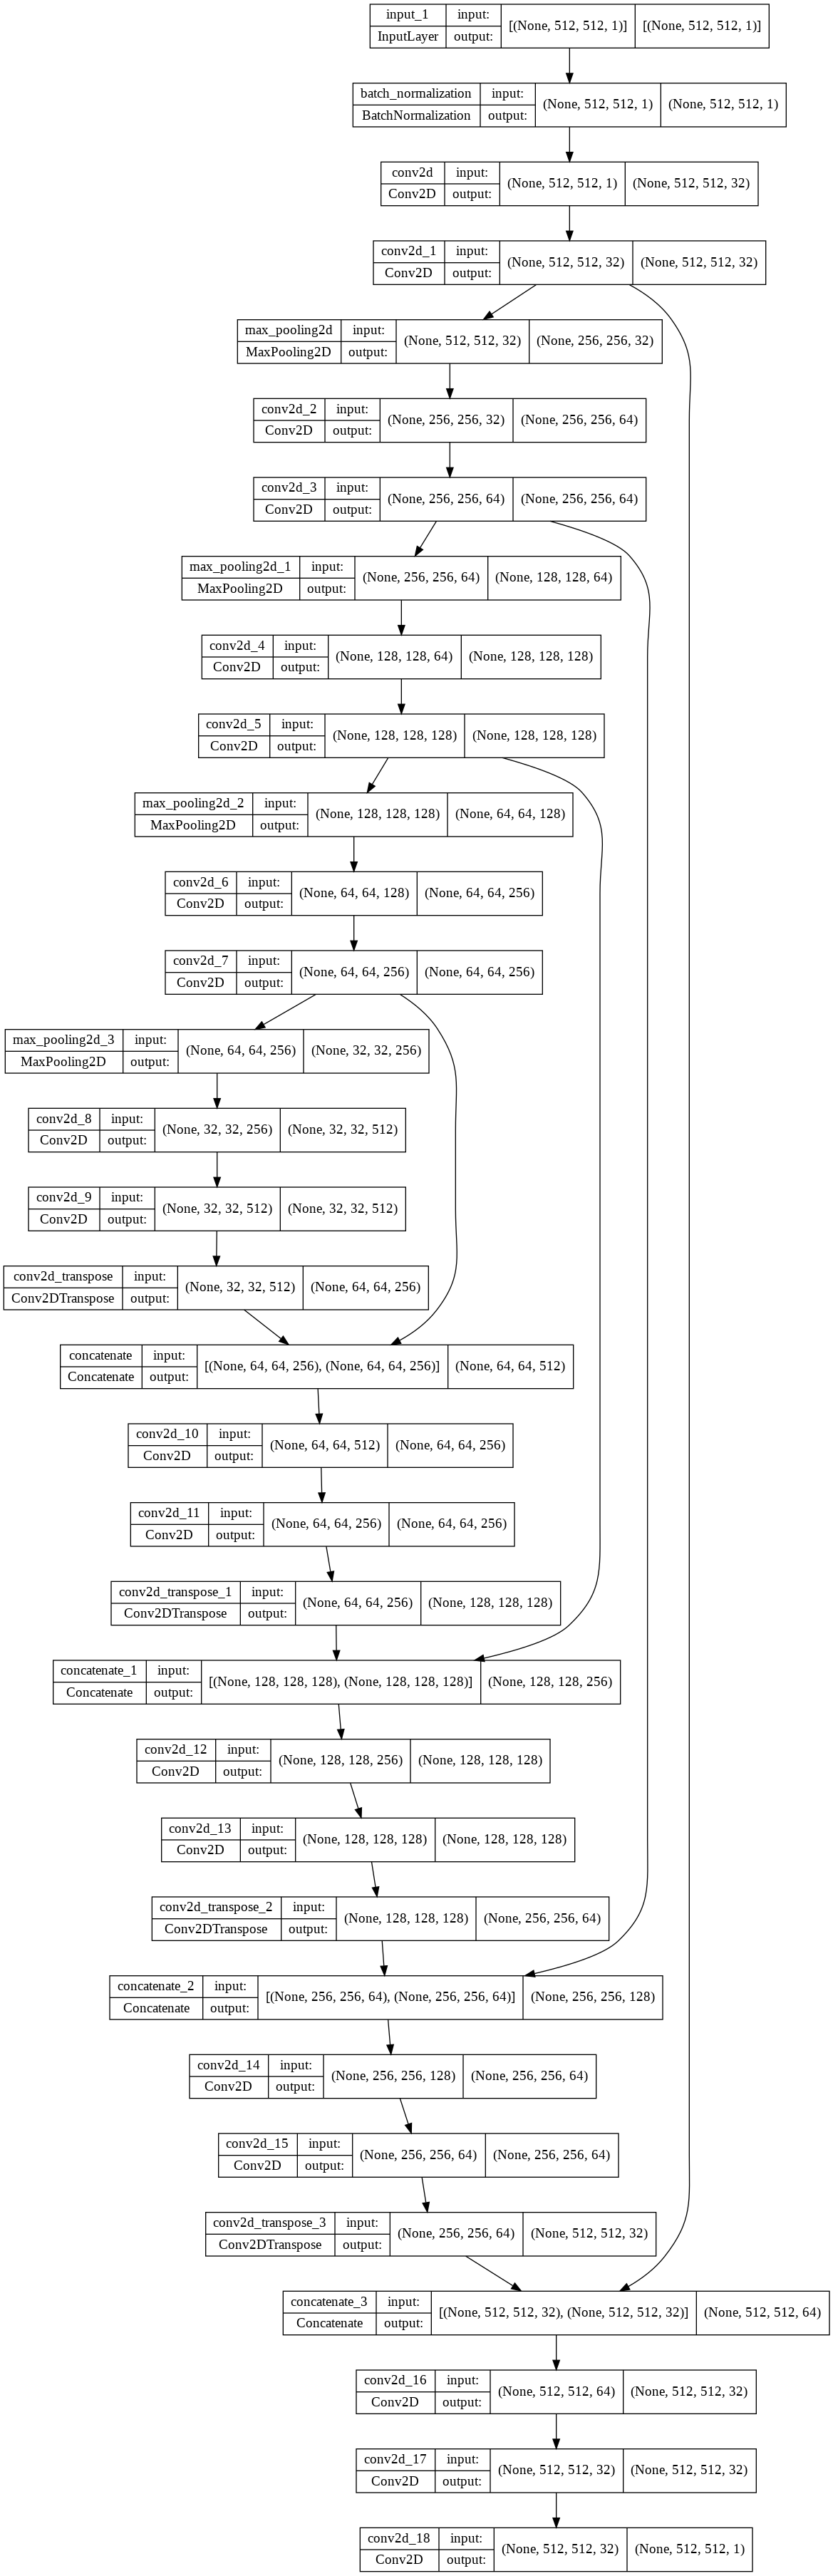

In [15]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [16]:
print(model.history.history)

{'loss': [0.17793118953704834, 0.027304859831929207, 0.02264982834458351, 0.01963106542825699, 0.018303314223885536, 0.017724262550473213, 0.01599530130624771, 0.015624582767486572, 0.016266878694295883, 0.014098680578172207, 0.01311235036700964, 0.012782278470695019, 0.012812584638595581, 0.01227372232824564, 0.011948518455028534, 0.011210136115550995, 0.010205174796283245, 0.010463891550898552, 0.009450918063521385, 0.010724879801273346], 'binary_crossentropy': [0.18258154392242432, 0.032717540860176086, 0.027629144489765167, 0.02442612312734127, 0.02291547693312168, 0.02203202061355114, 0.019831636920571327, 0.01919771172106266, 0.019865985959768295, 0.01694505661725998, 0.015688559040427208, 0.015192961320281029, 0.015331626869738102, 0.01457566674798727, 0.014287285506725311, 0.013111085630953312, 0.012022004462778568, 0.01239614188671112, 0.010956961661577225, 0.012777146883308887], 'generalized_dice_coefficient': [0.8267195820808411, 0.9781078100204468, 0.982329785823822, 0.9851

In [17]:
model.history.history['binary_crossentropy']

[0.18258154392242432,
 0.032717540860176086,
 0.027629144489765167,
 0.02442612312734127,
 0.02291547693312168,
 0.02203202061355114,
 0.019831636920571327,
 0.01919771172106266,
 0.019865985959768295,
 0.01694505661725998,
 0.015688559040427208,
 0.015192961320281029,
 0.015331626869738102,
 0.01457566674798727,
 0.014287285506725311,
 0.013111085630953312,
 0.012022004462778568,
 0.01239614188671112,
 0.010956961661577225,
 0.012777146883308887]

In [18]:
loss = model.history.history['loss']

In [19]:
loss

[0.17793118953704834,
 0.027304859831929207,
 0.02264982834458351,
 0.01963106542825699,
 0.018303314223885536,
 0.017724262550473213,
 0.01599530130624771,
 0.015624582767486572,
 0.016266878694295883,
 0.014098680578172207,
 0.01311235036700964,
 0.012782278470695019,
 0.012812584638595581,
 0.01227372232824564,
 0.011948518455028534,
 0.011210136115550995,
 0.010205174796283245,
 0.010463891550898552,
 0.009450918063521385,
 0.010724879801273346]

In [20]:
val_loss = model.history.history['val_loss']

In [21]:
val_loss

[0.07253668457269669,
 0.020080816000699997,
 0.016566099599003792,
 0.011156792752444744,
 0.018271571025252342,
 0.009268702007830143,
 0.01083239447325468,
 0.015451242215931416,
 0.011865219101309776,
 0.011326356790959835,
 0.016818419098854065,
 0.009258143603801727,
 0.012793152593076229,
 0.008529122918844223,
 0.01047687977552414,
 0.007357688155025244,
 0.011407880112528801,
 0.01158661488443613,
 0.007494669873267412,
 0.01068281102925539]

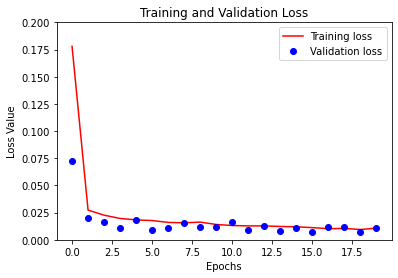

In [23]:
epochs = range(20)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.ylim([0, 0.2])
plt.legend()
plt.show()

In [ ]:
train_imgs[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
train_imgs[1].max()

1.0

In [ ]:
train_imgs[1].min()

0.0

In [ ]:
type(train_imgs[1])

numpy.ndarray

## LOAD THE SAVED MODEL

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/segmentation/my_model_3.h5',custom_objects={'bce_dice_loss': bce_dice_loss,'generalized_dice_coefficient': generalized_dice_coefficient} )

In [ ]:
val_loss

[0.6626728773117065,
 0.22035452723503113,
 0.23536120355129242,
 0.05059905722737312,
 0.061391644179821014,
 0.03068089298903942,
 0.026920514181256294,
 0.01796587184071541,
 0.020082978531718254,
 0.01840030774474144]

In [ ]:
model.variables[10]

<tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[-5.57130910e-02,  3.14530507e-02,  4.65035364e-02, ...,
          -4.65356074e-02,  4.36540768e-02, -5.58035001e-02],
         [-2.03714725e-02, -2.04680674e-02,  4.84713241e-02, ...,
           4.91894130e-03, -5.78515008e-02,  3.99216563e-02],
         [ 4.73390557e-02,  9.63246748e-02, -7.31555447e-02, ...,
          -4.64508906e-02,  4.16692421e-02,  1.69102028e-02],
         ...,
         [ 5.93219772e-02,  3.18793319e-02, -2.75058094e-02, ...,
           1.24014989e-02, -2.69620344e-02, -5.65812774e-02],
         [-7.72265112e-03,  8.39553401e-02, -9.38503165e-03, ...,
           7.38599747e-02, -3.31584141e-02, -4.81443666e-02],
         [ 6.93676434e-03,  6.84185699e-02, -6.35510534e-02, ...,
          -5.01355529e-02,  1.80032253e-02, -8.13515764e-03]],

        [[-9.93285049e-03, -6.00530803e-02,  7.74538219e-02, ...,
           7.73206204e-02,  1.11381281e-02,  2.38900483e-02],
         [-3

In [ ]:
a = new_model.variables[10]

In [ ]:
b = a.numpy()

In [ ]:
sum = 0

for i in b[0][0][0]:
    i = ++i

print(i)


0.06508172


In [ ]:
file_list = sorted(glob(root+idx_path+data_path[1]+'*.jpg'))
predic = []

predic = train_imgs[:10]

for elem in file_list:
    img_obj = cv2.imread(elem, cv2.IMREAD_UNCHANGED)
    predic.append(img_obj)

prediction = np.array(predic)

In [ ]:
predictions = np.array(train_imgs[:10])

In [27]:
pred_imgs = []

f_list = sorted(glob("/content/drive/MyDrive/segmentation/data/seg_012/seg_012_2/dicom/*.dcm"))

def normalize_conf(input_arr):
    Max_val = np.max(input_arr)
    Min_val = np.min(input_arr)
    Up_arr = input_arr - Min_val
    Dn_arr = Max_val - Min_val
    normal_arr = Up_arr / Dn_arr
    return normal_arr

for elem in f_list:
    temp_pred = pydicom.dcmread(elem)
    temp_arry = temp_pred.pixel_array
    temp_norm = normalize_conf(temp_arry)
    pred_imgs.append(temp_norm)

pred_imgs = np.array(pred_imgs)

## PREDICT

In [28]:
pred_img = model.predict(pred_imgs)

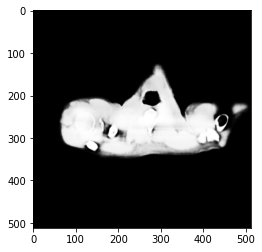

In [30]:
plt.imshow(np.squeeze(pred_img[0]), cmap=plt.cm.gray)

In [31]:
pred_img[pred_img <=0.5] = 0
pred_img[pred_img > 0.5] = 1

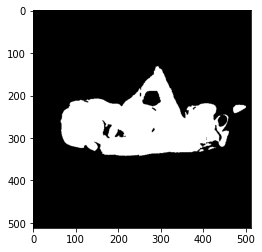

In [33]:
plt.imshow(np.squeeze(pred_img[0]), cmap=plt.cm.gray)

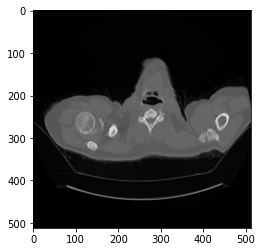

In [34]:
plt.imshow(pred_imgs[0], cmap=plt.cm.gray)

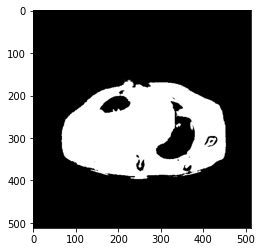

In [37]:
plt.imshow(np.squeeze(pred_img[50]), cmap=plt.cm.gray)

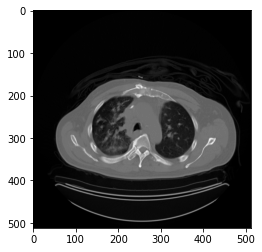

In [36]:
plt.imshow(pred_imgs[50], cmap=plt.cm.gray)

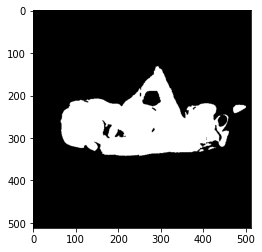

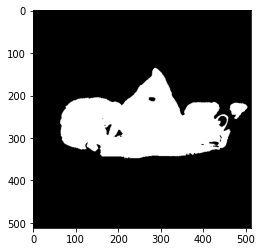

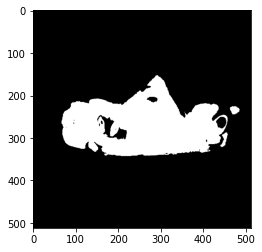

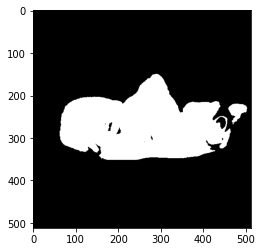

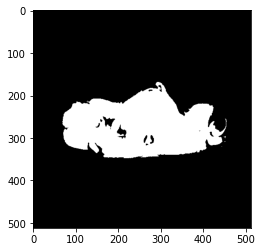

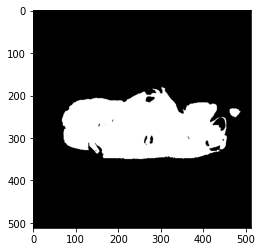

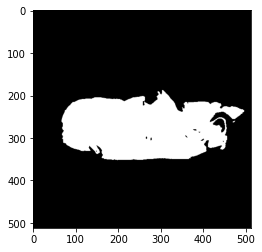

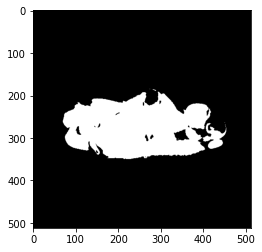

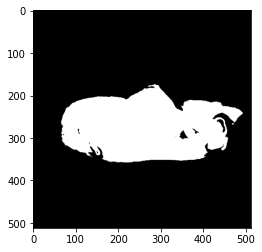

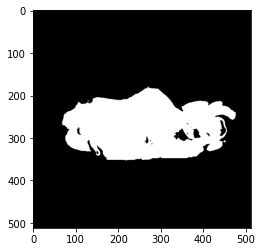

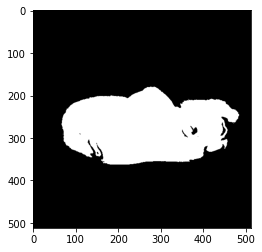

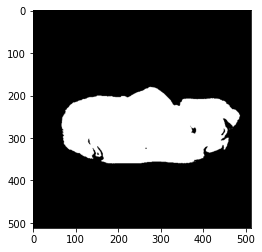

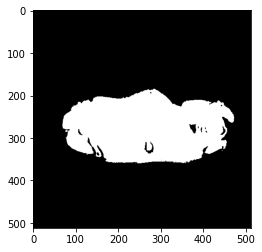

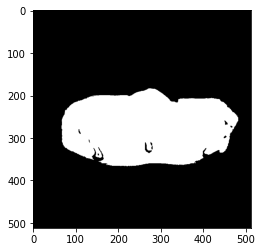

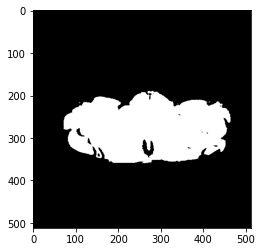

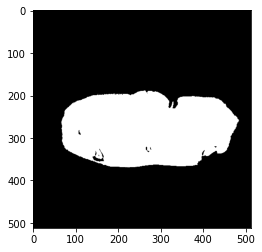

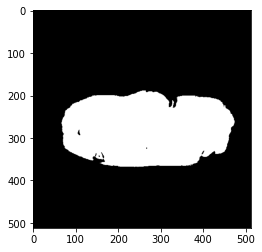

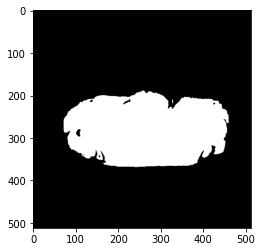

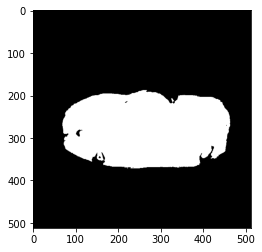

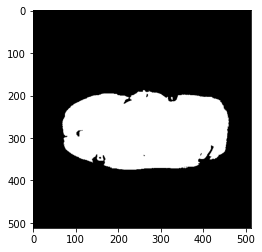

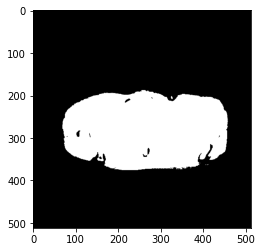

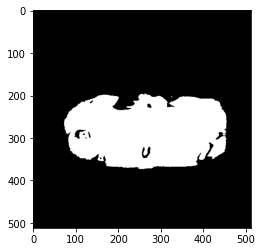

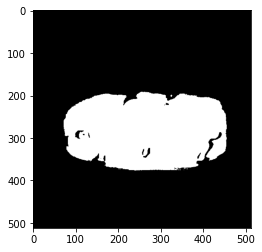

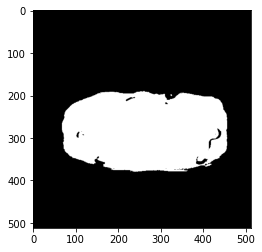

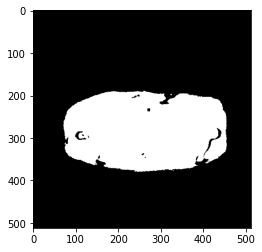

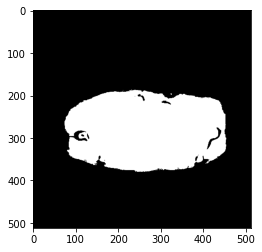

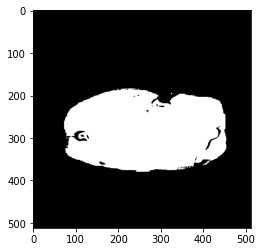

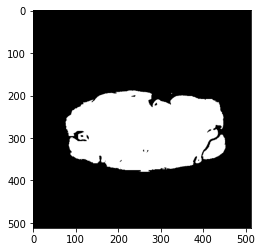

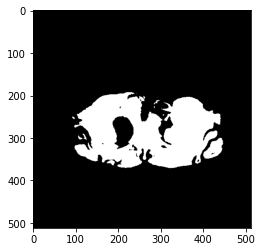

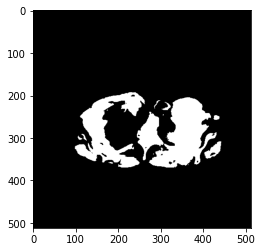

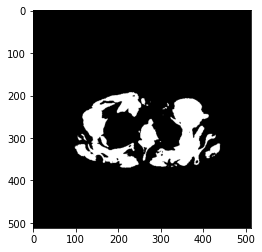

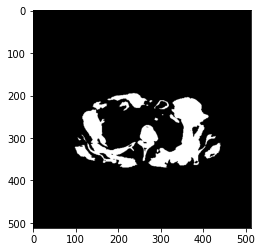

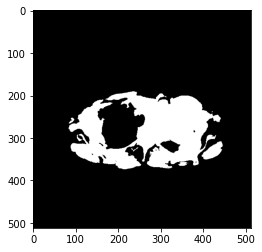

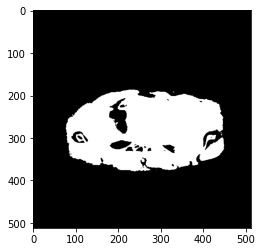

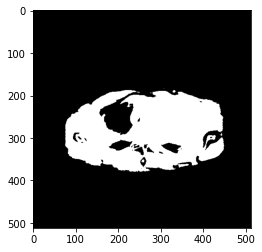

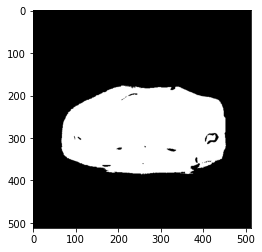

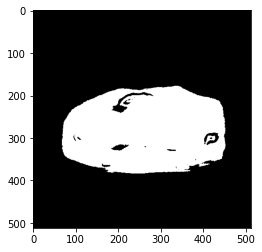

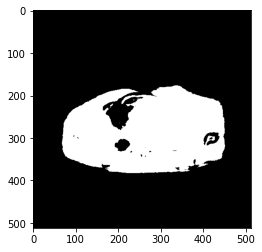

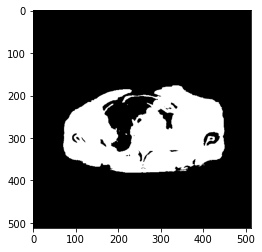

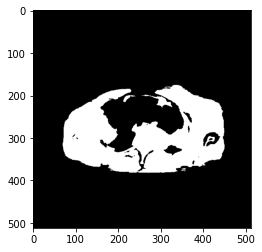

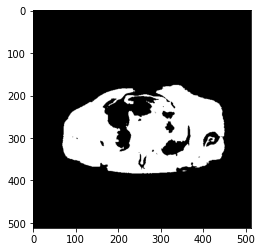

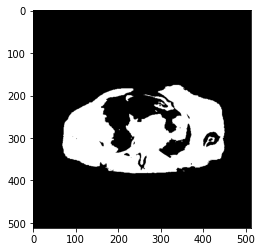

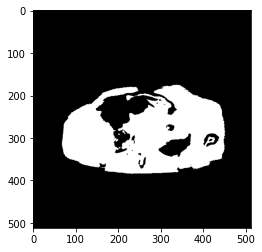

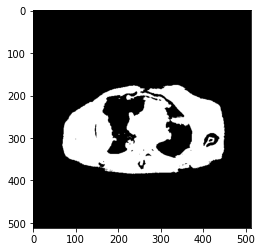

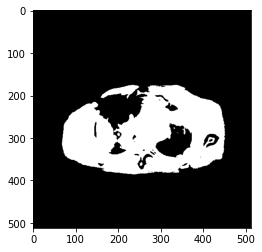

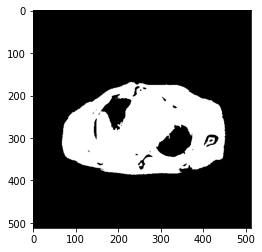

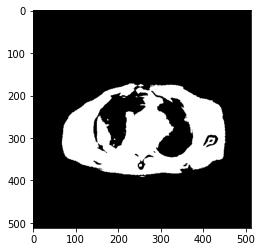

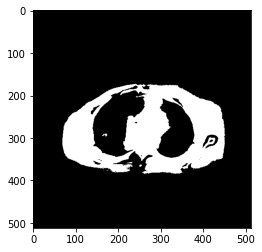

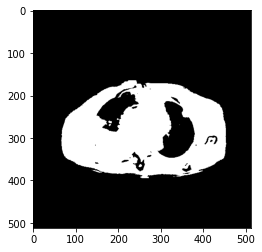

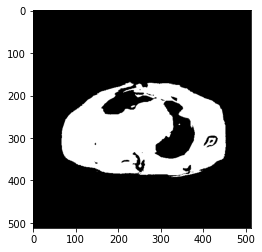

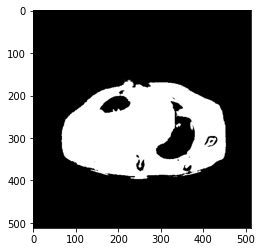

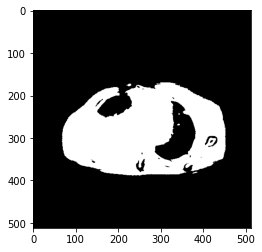

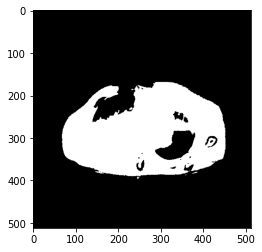

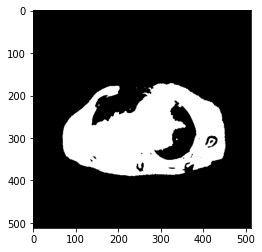

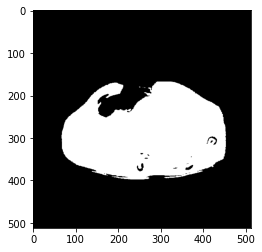

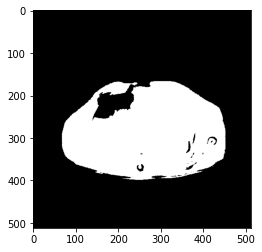

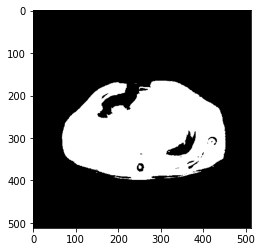

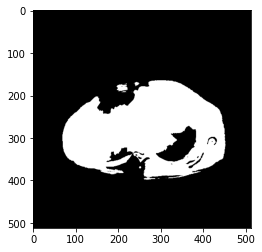

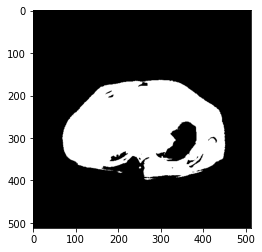

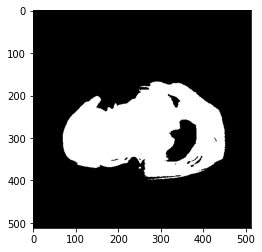

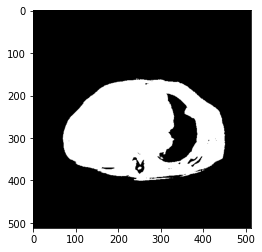

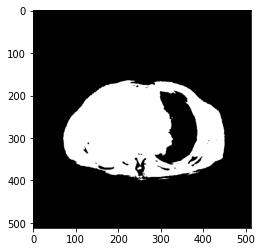

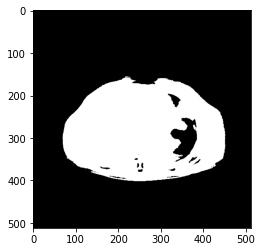

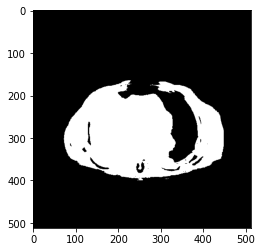

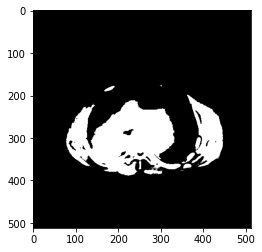

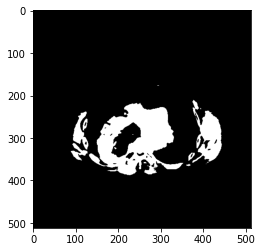

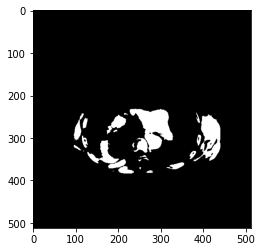

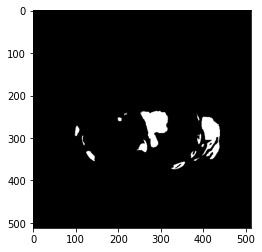

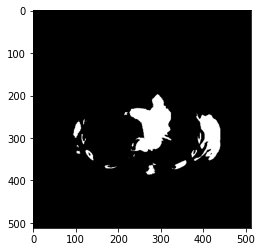

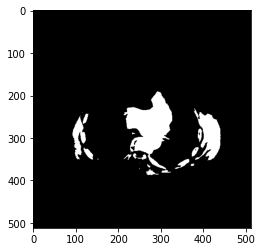

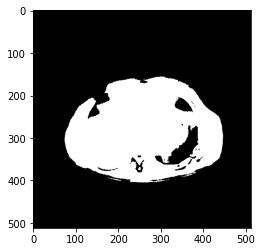

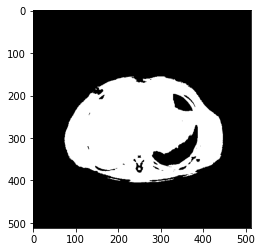

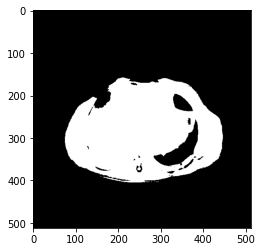

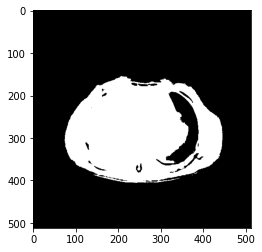

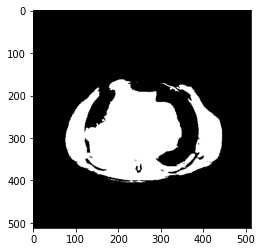

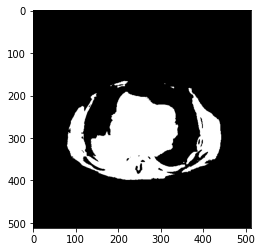

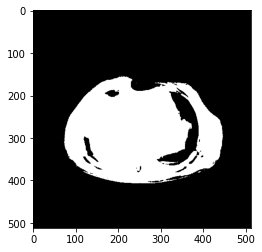

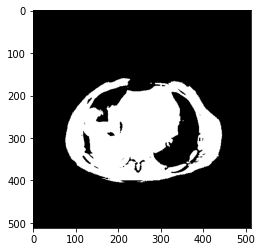

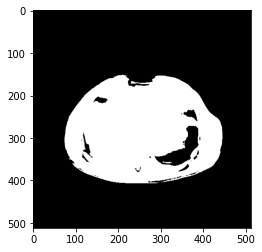

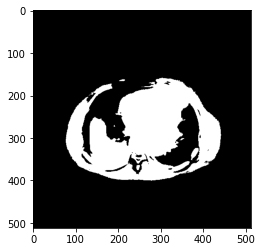

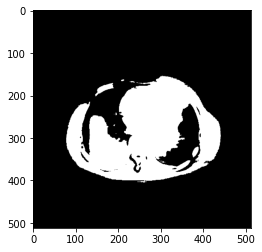

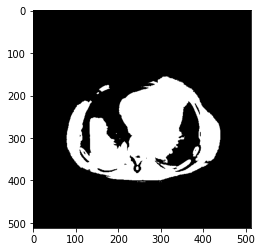

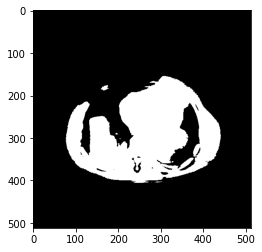

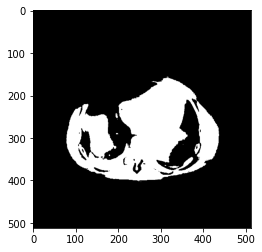

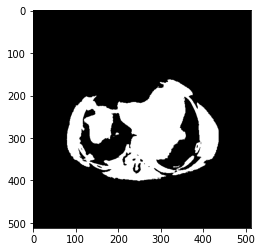

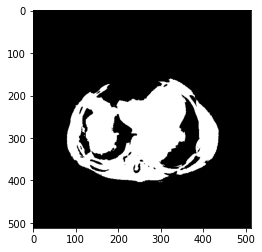

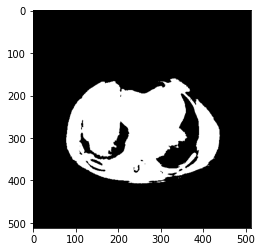

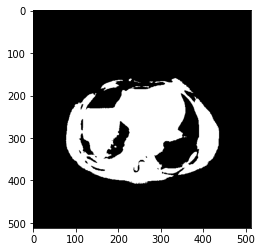

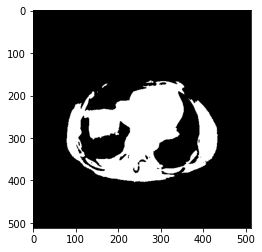

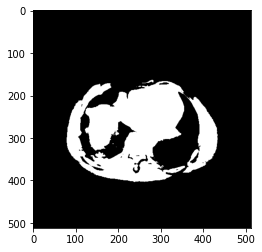

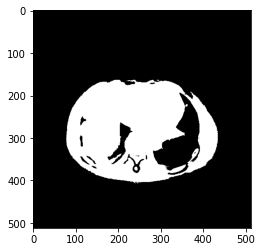

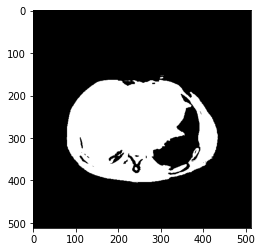

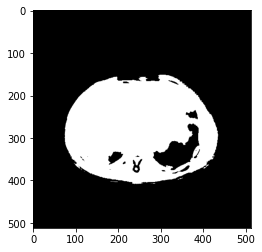

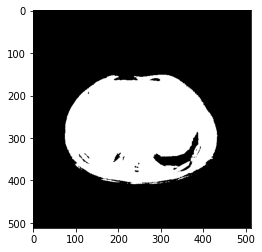

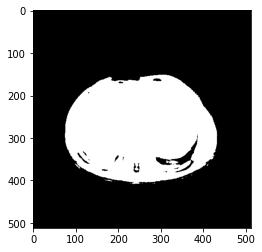

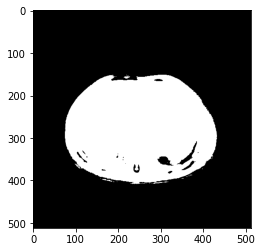

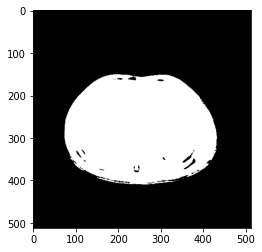

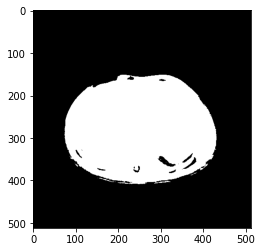

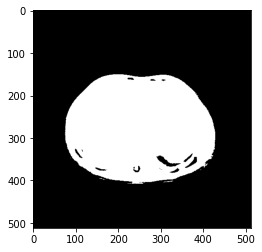

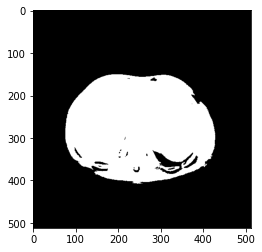

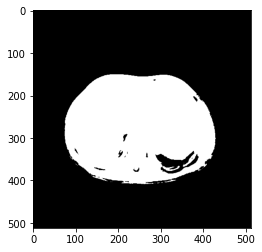

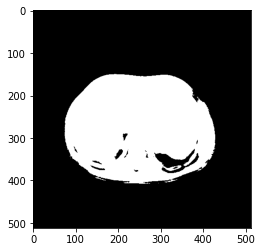

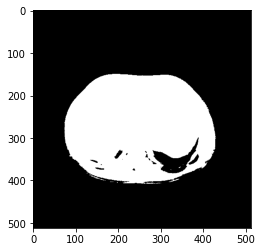

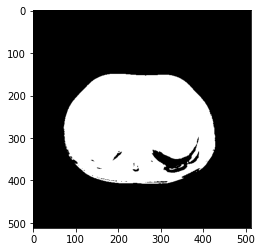

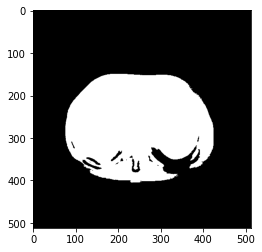

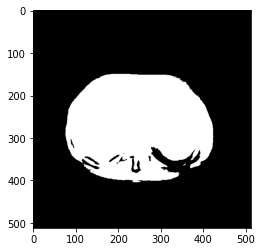

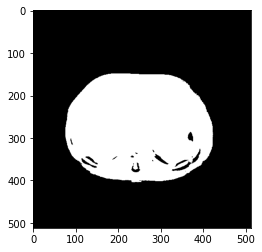

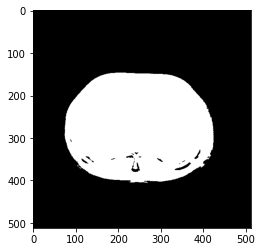

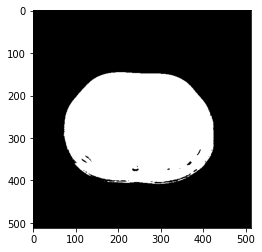

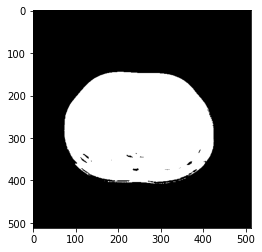

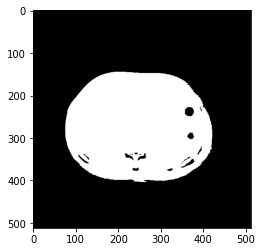

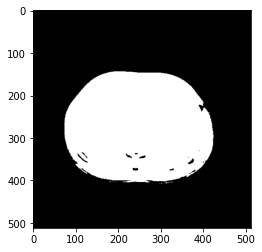

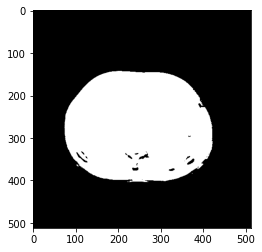

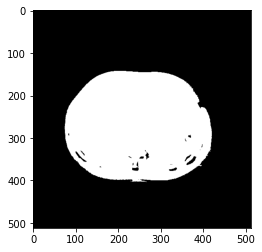

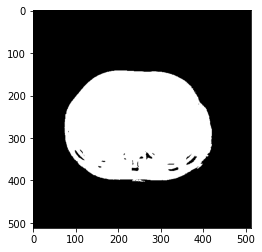

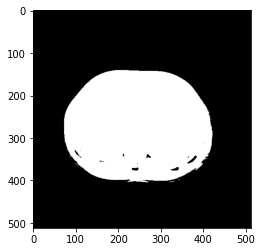

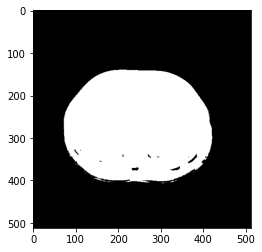

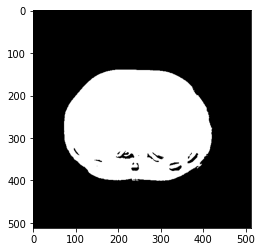

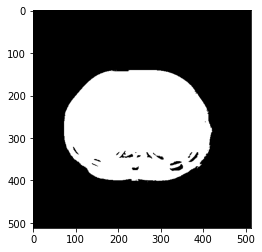

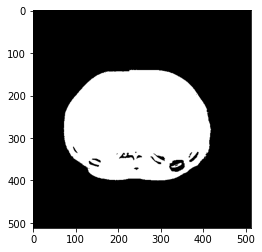

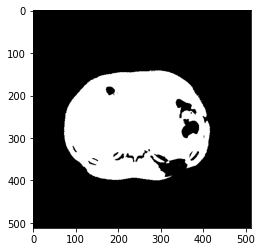

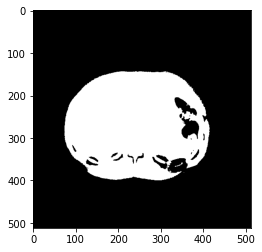

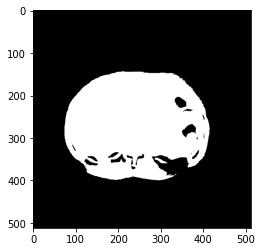

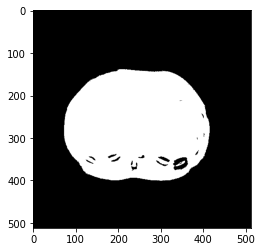

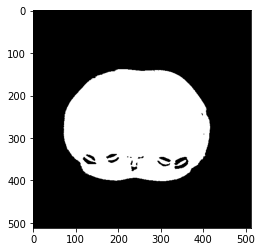

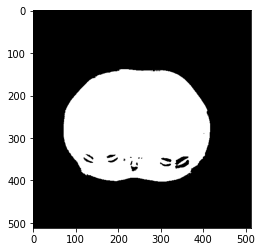

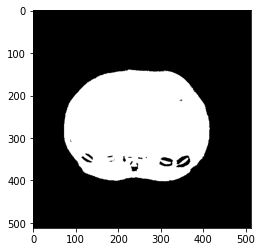

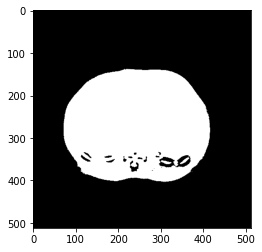

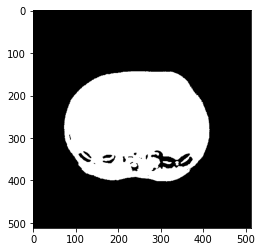

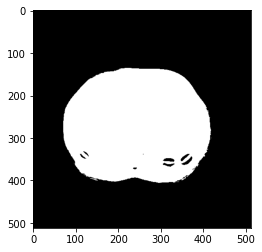

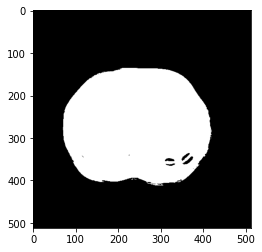

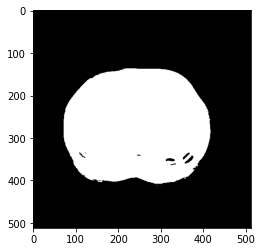

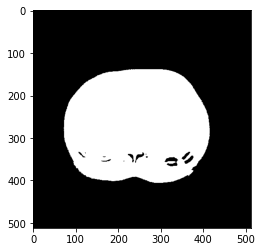

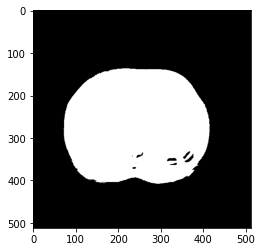

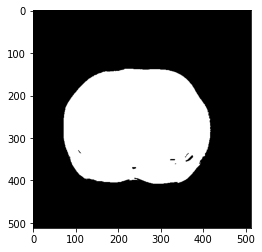

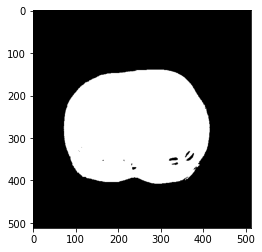

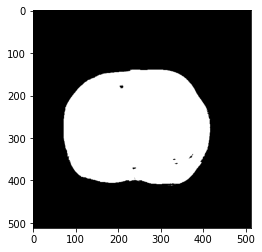

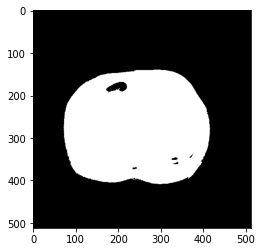

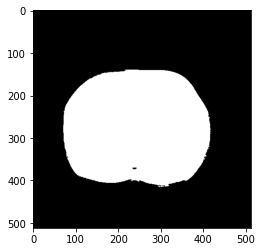

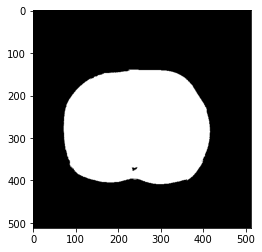

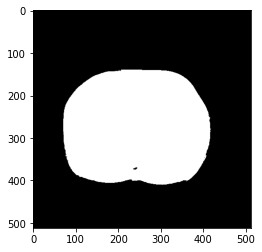

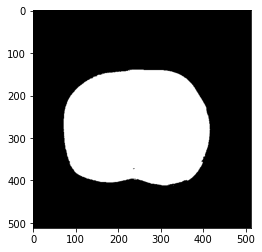

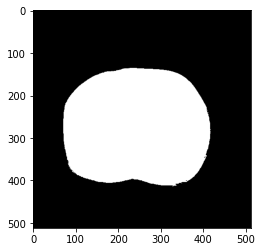

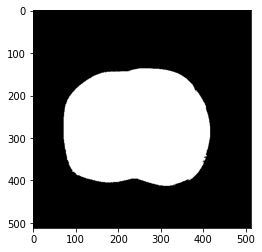

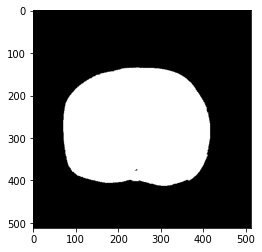

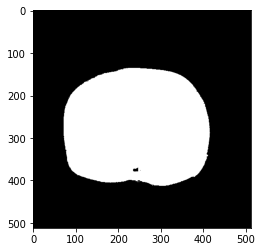

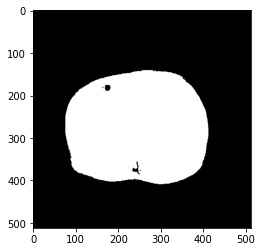

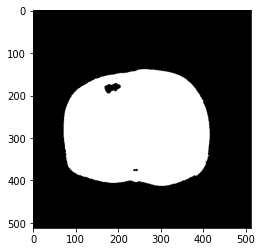

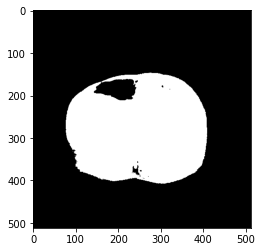

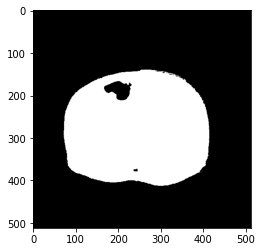

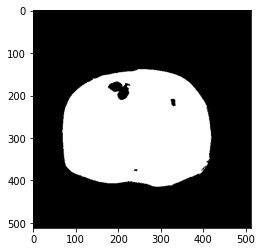

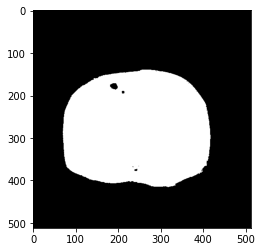

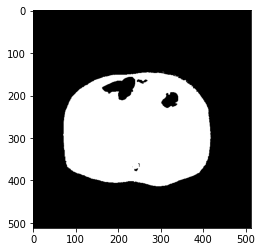

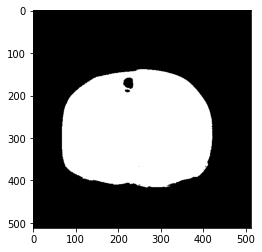

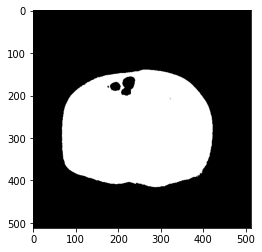

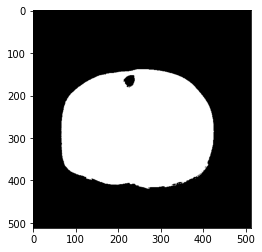

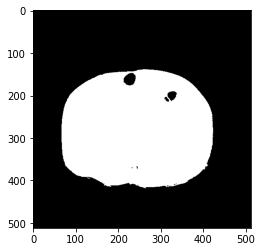

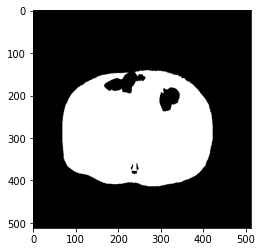

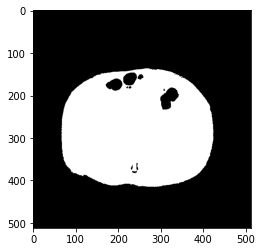

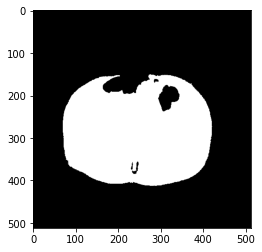

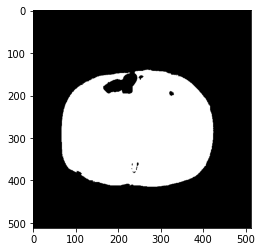

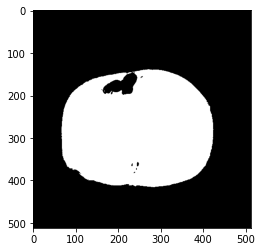

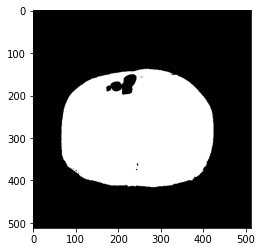

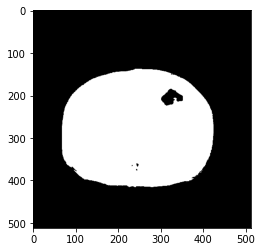

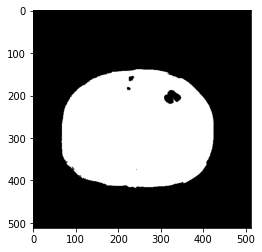

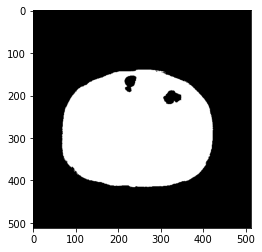

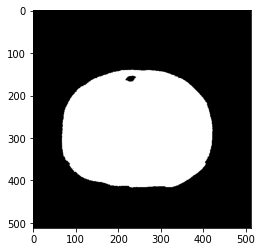

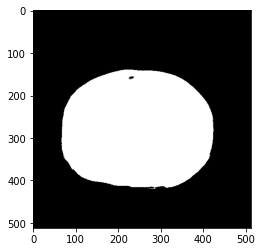

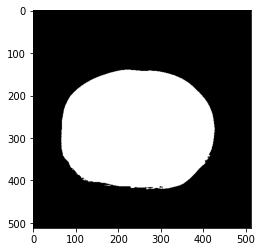

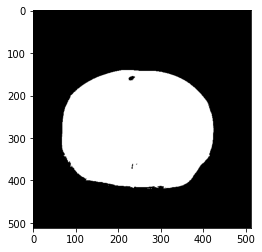

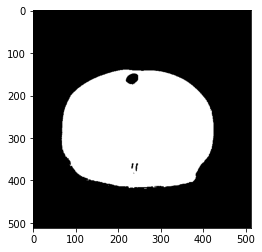

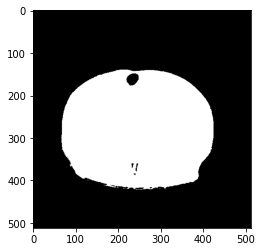

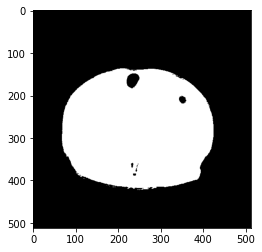

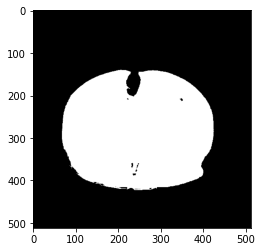

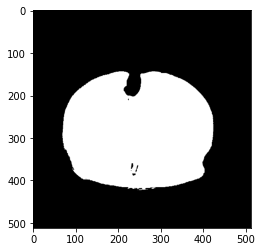

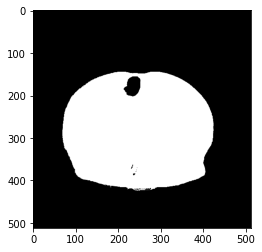

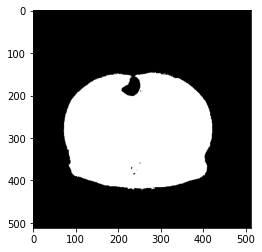

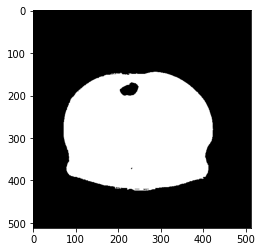

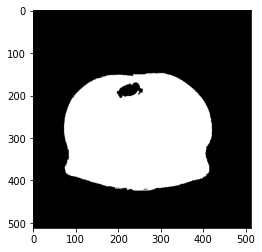

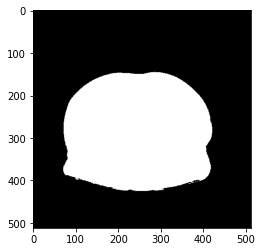

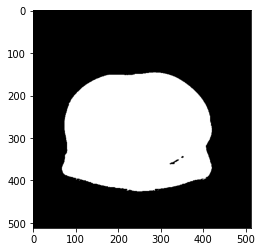

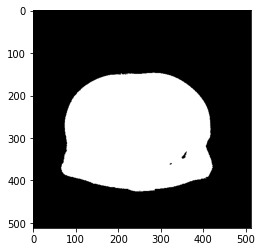

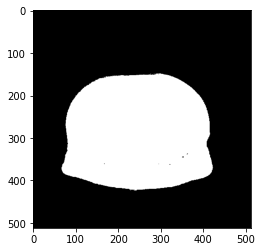

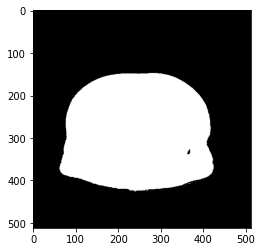

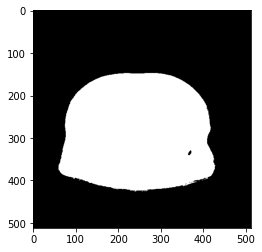

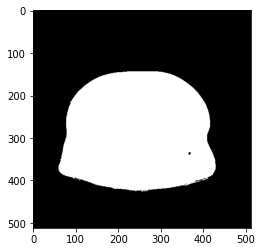

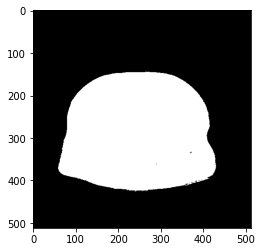

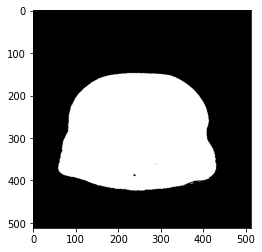

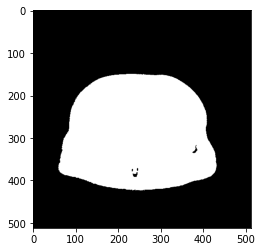

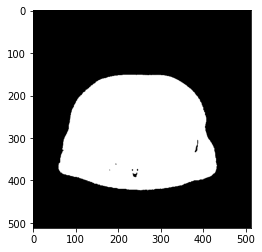

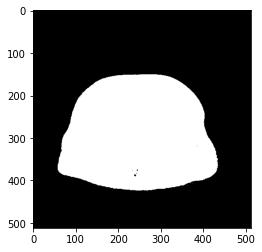

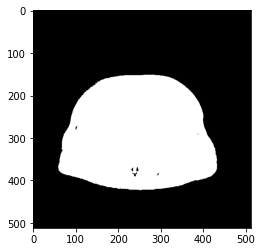

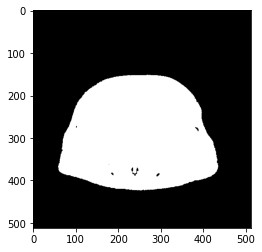

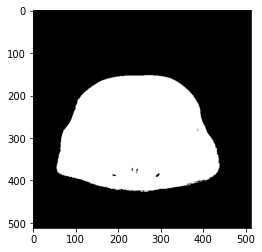

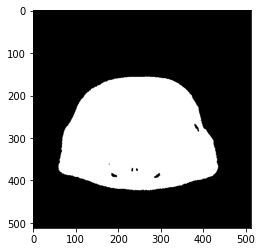

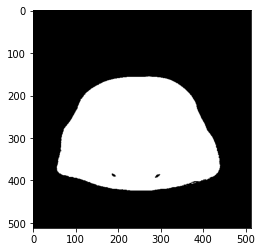

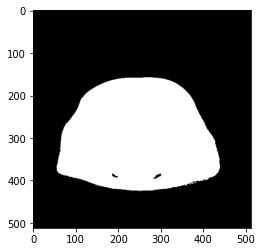

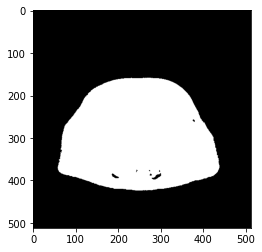

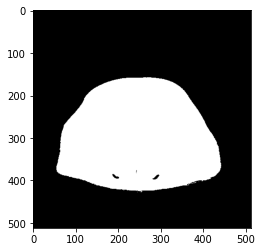

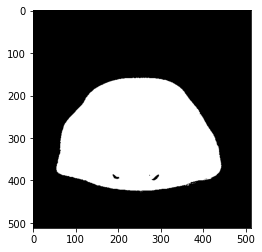

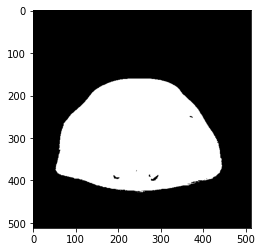

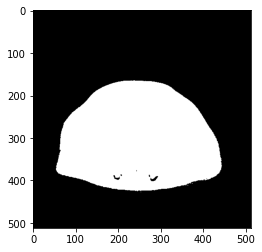

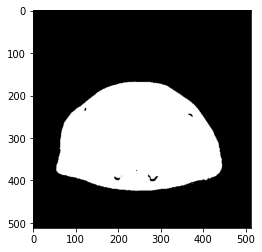

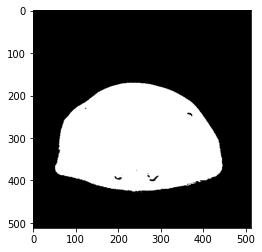

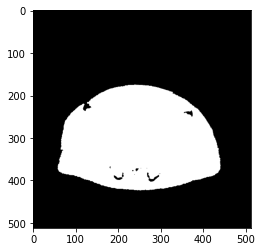

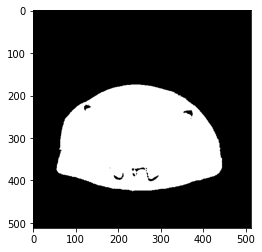

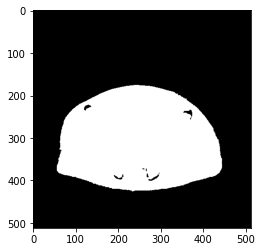

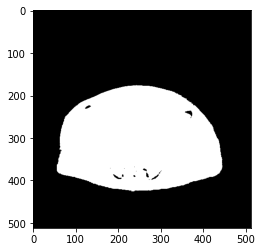

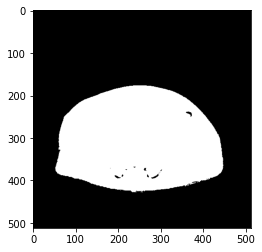

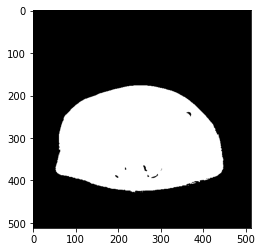

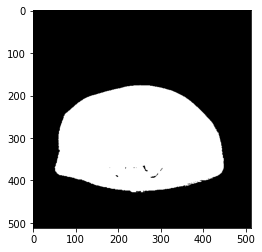

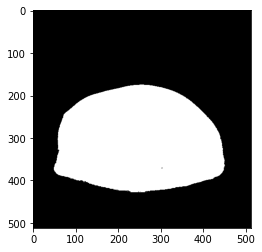

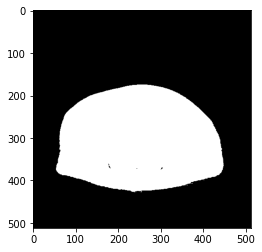

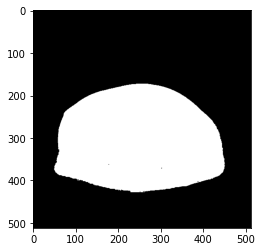

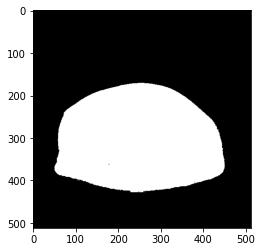

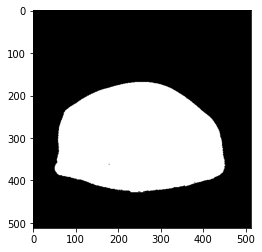

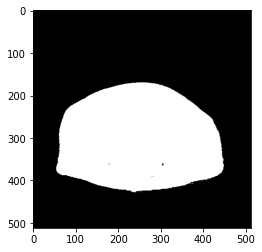

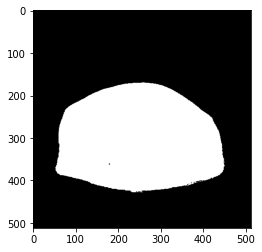

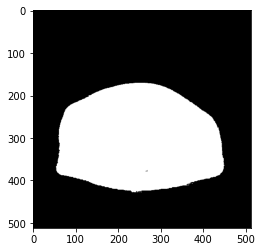

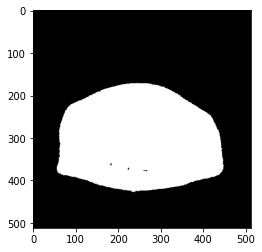

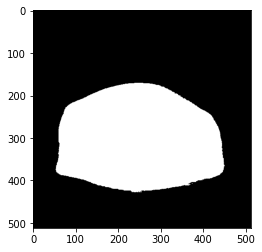

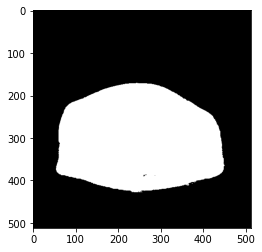

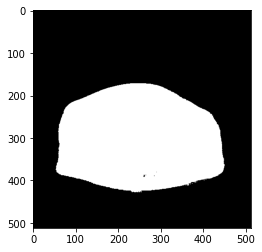

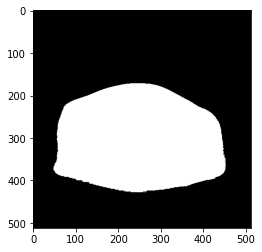

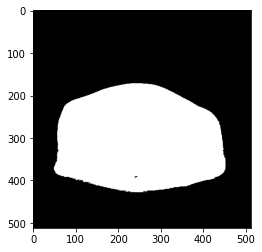

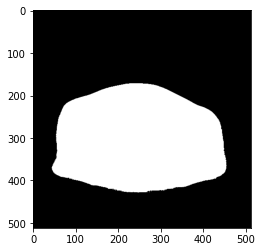

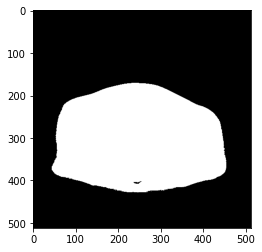

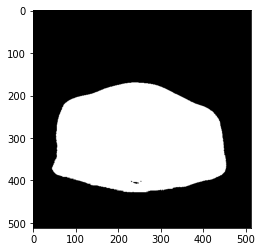

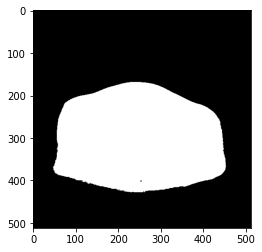

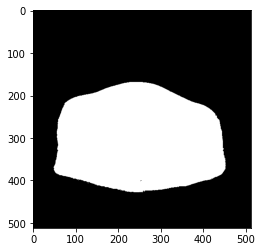

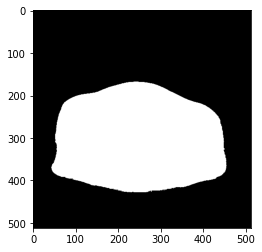

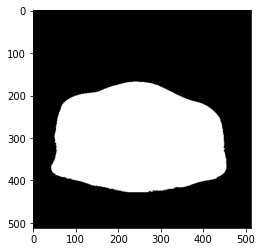

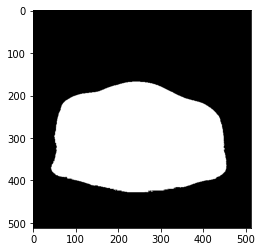

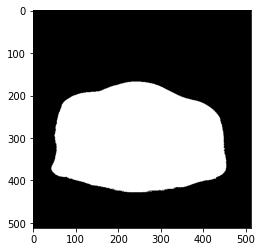

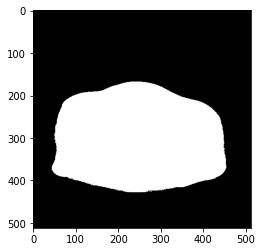

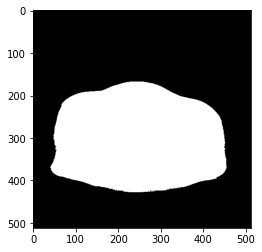

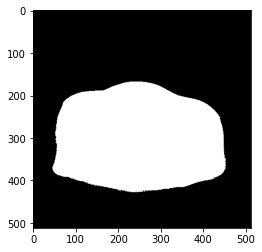

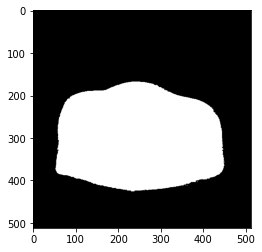

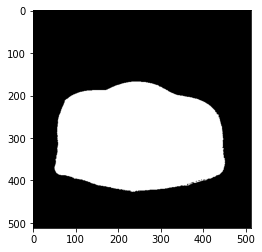

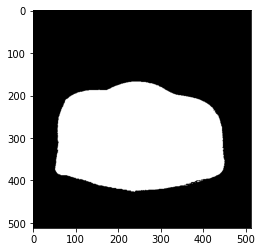

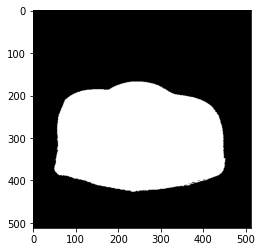

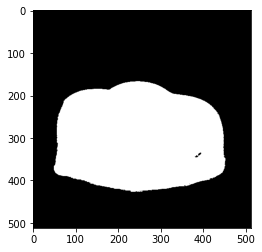

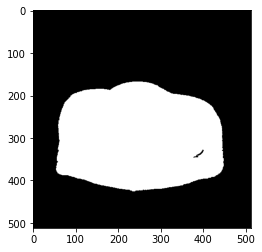

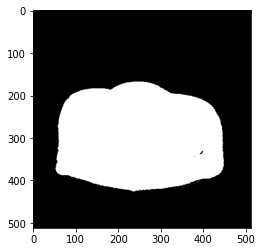

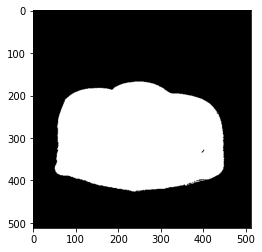

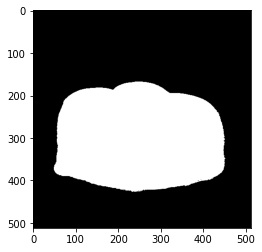

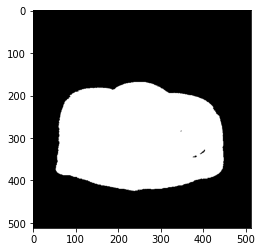

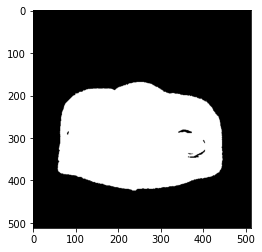

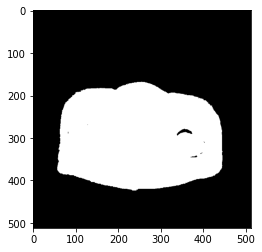

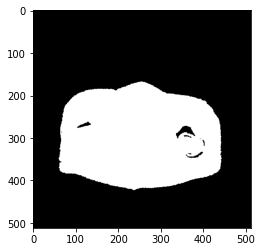

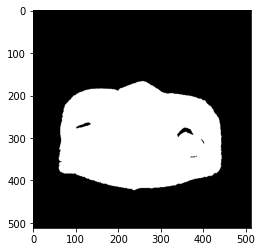

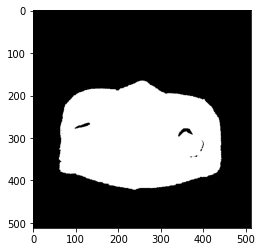

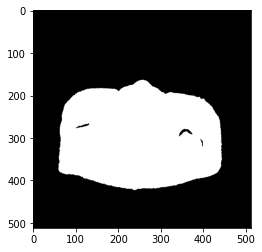

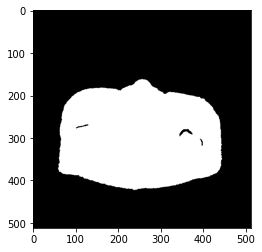

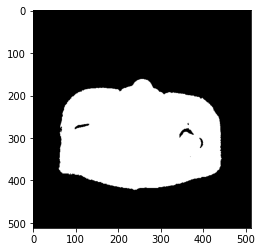

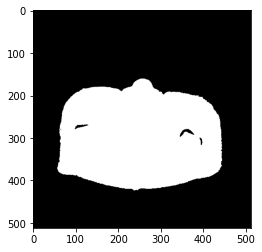

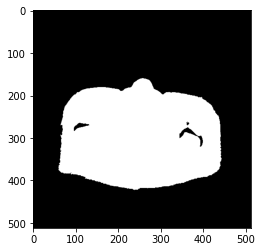

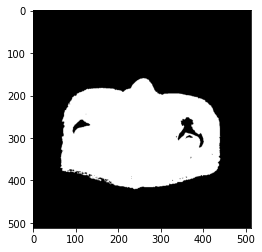

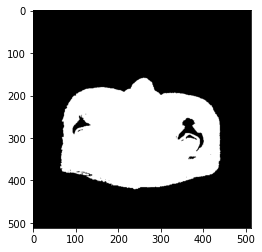

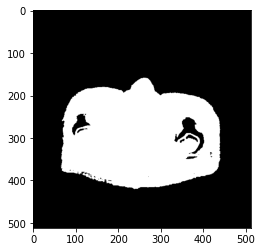

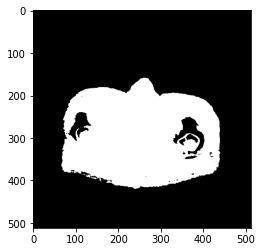

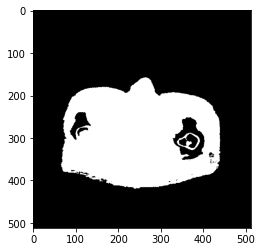

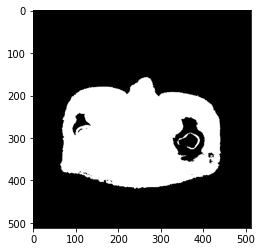

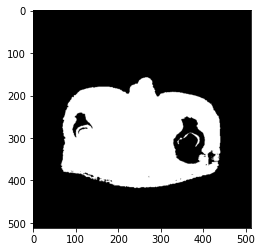

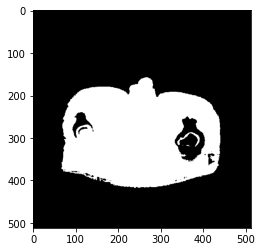

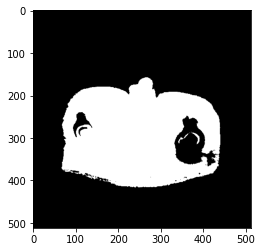

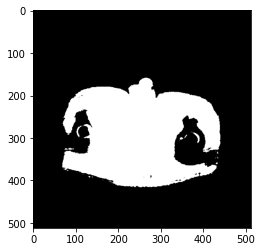

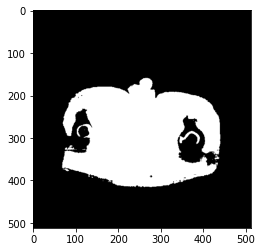

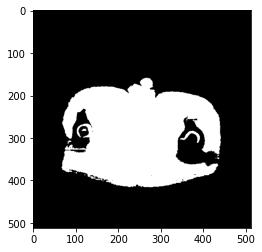

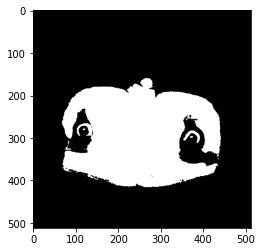

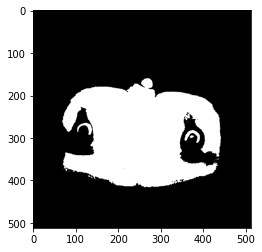

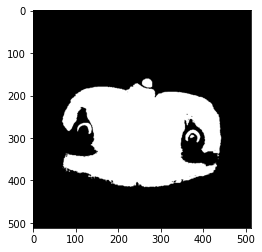

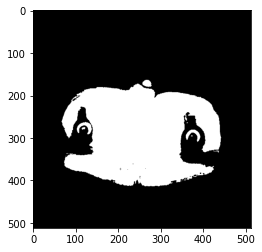

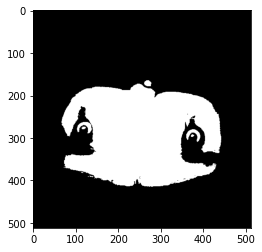

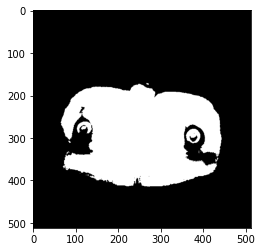

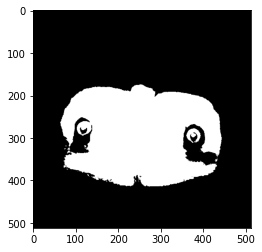

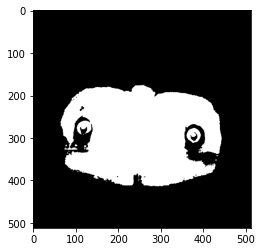

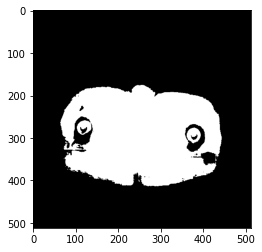

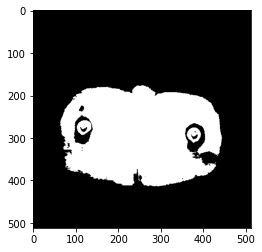

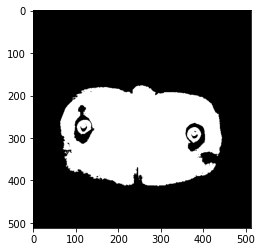

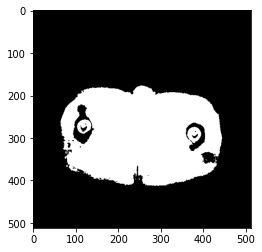

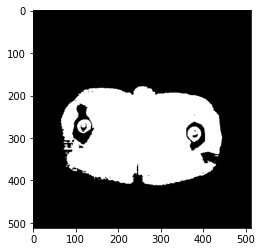

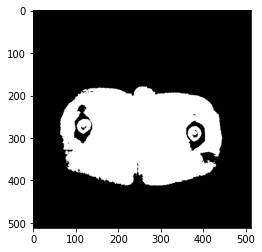

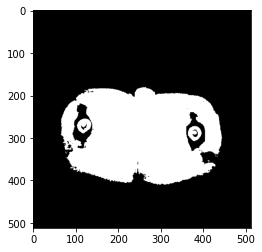

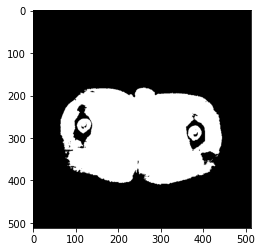

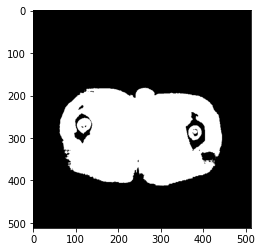

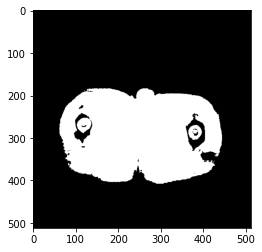

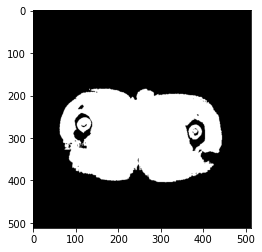

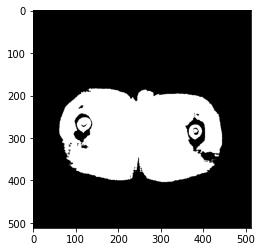

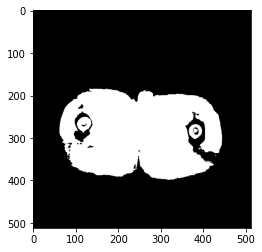

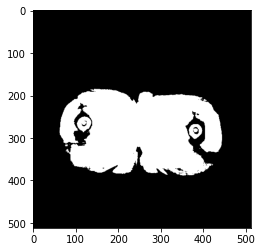

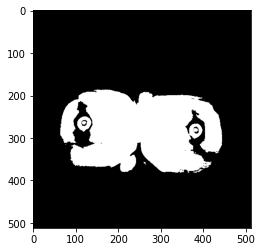

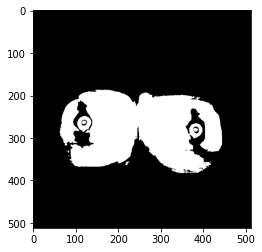

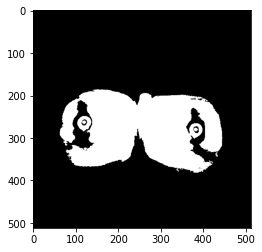

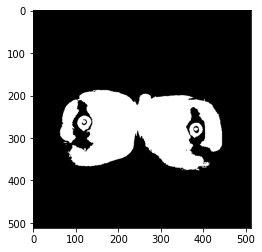

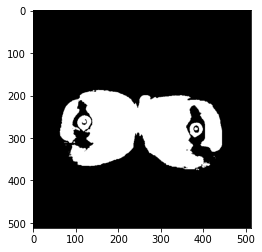

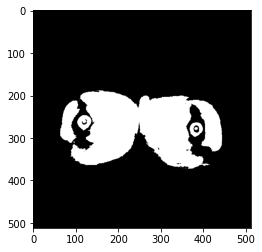

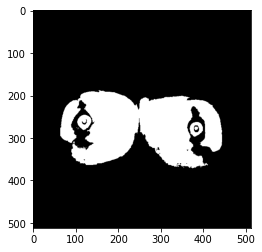

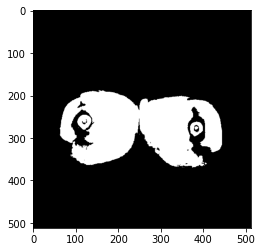

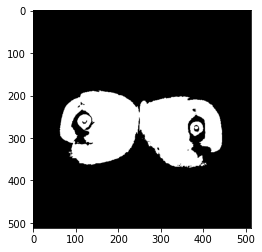

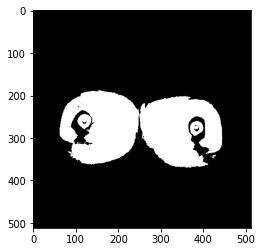

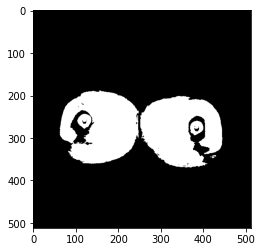

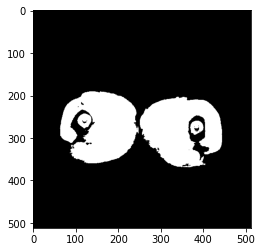

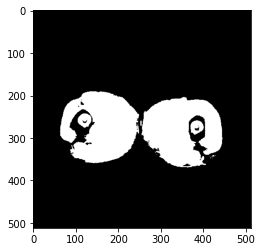

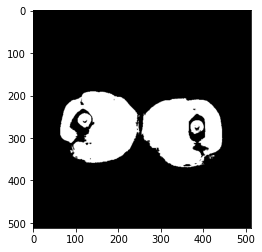

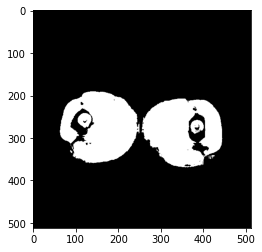

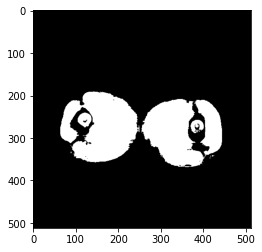

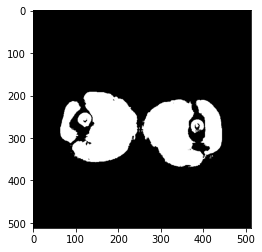

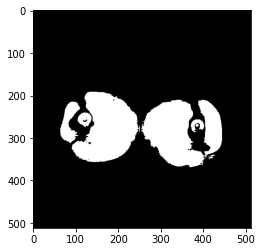

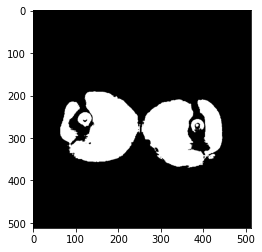

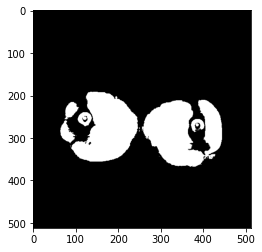

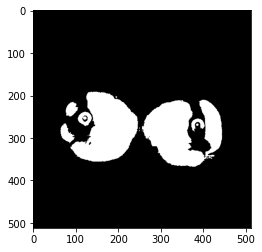

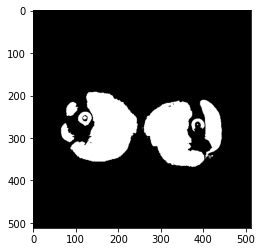

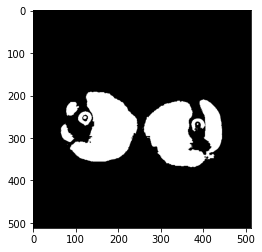

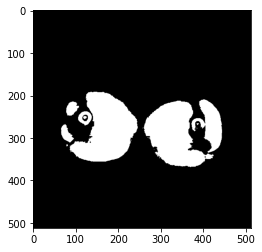

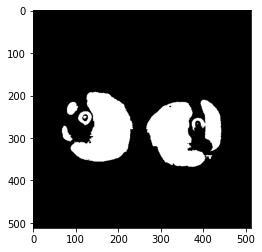

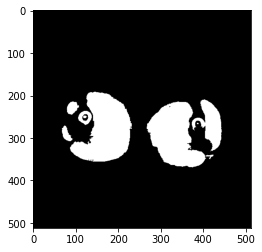

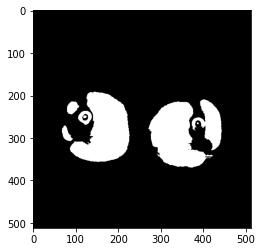

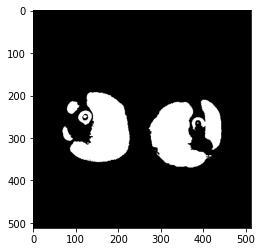

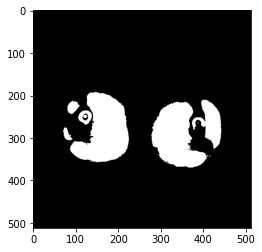

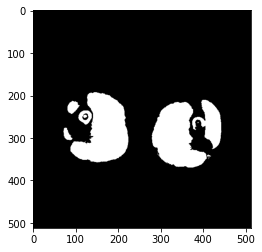

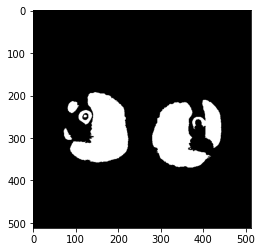

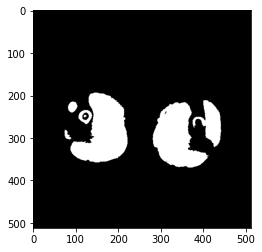

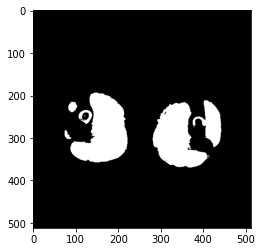

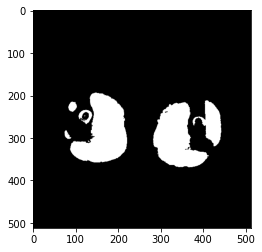

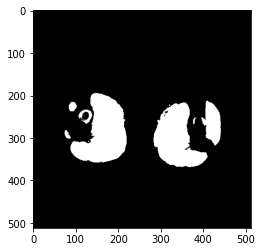

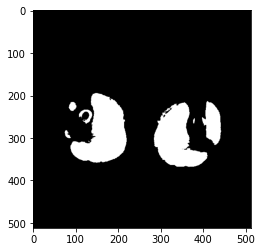

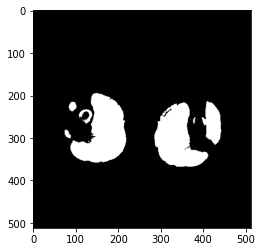

In [38]:
for elem in pred_img:
    plt.imshow(np.squeeze(elem), cmap=plt.cm.gray)
    plt.show()

In [ ]:
plt_imgs = np.squeeze(pred_img)

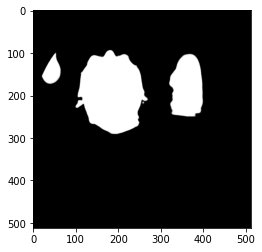

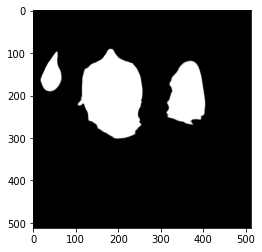

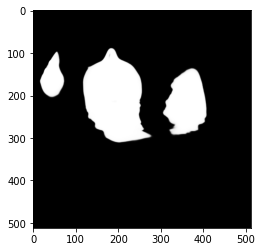

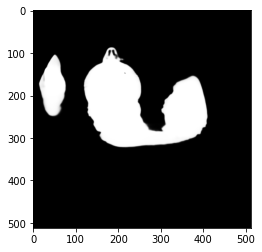

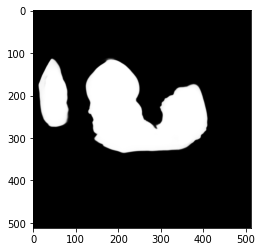

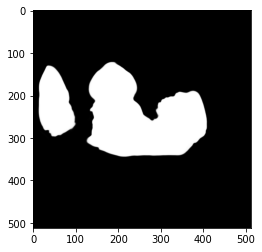

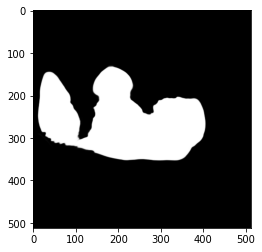

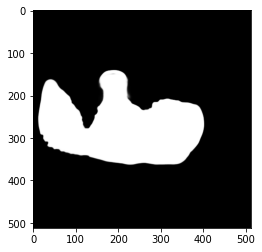

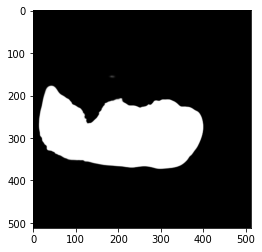

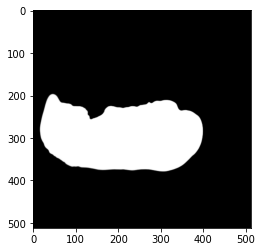

In [ ]:
for elem in plt_imgs:
    plt.imshow(elem, cmap='gray')
    plt.show()

In [ ]:
for i in range(100):
    fig = plt.figure(0, figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    plt.imshow(pred_imgs[i], cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(np.squeeze(plt_imgs[i]), cmap='gray')
    plt.show()

In [ ]:
plt_img = np.squeeze(pred_img[0])

In [ ]:
# https://github.com/shruti-jadon/Semantic-Segmentation-Loss-Functions/blob/master/loss_functions.py

import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1


class Semantic_loss_functions(object):
    def __init__(self):
        print ("semantic loss functions initialized")

    def dice_coef(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + K.epsilon()) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

    def sensitivity(self, y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

    def specificity(self, y_true, y_pred):
        true_negatives = K.sum(
            K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
        return true_negatives / (possible_negatives + K.epsilon())

    def convert_to_logits(self, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                                  1 - tf.keras.backend.epsilon())
        return tf.math.log(y_pred / (1 - y_pred))

    def weighted_cross_entropyloss(self, y_true, y_pred):
        y_pred = self.convert_to_logits(y_pred)
        pos_weight = beta / (1 - beta)
        loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred,
                                                        targets=y_true,
                                                        pos_weight=pos_weight)
        return tf.reduce_mean(loss)

    def focal_loss_with_logits(self, logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)

        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(
            -logits)) * (weight_a + weight_b) + logits * weight_b

    def focal_loss(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                                  1 - tf.keras.backend.epsilon())
        logits = tf.math.log(y_pred / (1 - y_pred))

        loss = self.focal_loss_with_logits(logits=logits, targets=y_true,
                                      alpha=alpha, gamma=gamma, y_pred=y_pred)

        return tf.reduce_mean(loss)

    def depth_softmax(self, matrix):
        sigmoid = lambda x: 1 / (1 + K.exp(-x))
        sigmoided_matrix = sigmoid(matrix)
        softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=0)
        return softmax_matrix

    def generalized_dice_coefficient(self, y_true, y_pred):
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        score = (2. * intersection + smooth) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return score

    def dice_loss(self, y_true, y_pred):
        loss = 1 - self.generalized_dice_coefficient(y_true, y_pred)
        return loss

    def bce_dice_loss(self, y_true, y_pred):
        loss = binary_crossentropy(y_true, y_pred) + \
               self.dice_loss(y_true, y_pred)
        return loss / 2.0

    def confusion(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.clip(y_pred, 0, 1)
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.clip(y_true, 0, 1)
        y_neg = 1 - y_pos
        tp = K.sum(y_pos * y_pred_pos)
        fp = K.sum(y_neg * y_pred_pos)
        fn = K.sum(y_pos * y_pred_neg)
        prec = (tp + smooth) / (tp + fp + smooth)
        recall = (tp + smooth) / (tp + fn + smooth)
        return prec, recall

    def true_positive(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pos = K.round(K.clip(y_true, 0, 1))
        tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
        return tp

    def true_negative(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
        return tn

    def tversky_index(self, y_true, y_pred):
        y_true_pos = K.flatten(y_true)
        y_pred_pos = K.flatten(y_pred)
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
        alpha = 0.7
        return (true_pos + smooth) / (true_pos + alpha * false_neg + (
                    1 - alpha) * false_pos + smooth)

    def tversky_loss(self, y_true, y_pred):
        return 1 - self.tversky_index(y_true, y_pred)

    def focal_tversky(self, y_true, y_pred):
        pt_1 = self.tversky_index(y_true, y_pred)
        gamma = 0.75
        return K.pow((1 - pt_1), gamma)

    def log_cosh_dice_loss(self, y_true, y_pred):
        x = self.dice_loss(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

In [ ]:
a =  Semantic_loss_functions()

semantic loss functions initialized


In [ ]:
b = a.dice_loss(pred_img[0],trut_msk[0])

In [ ]:
c = a.dice_coef(pred_img[0],trut_msk[0])
print(c.numpy())

0.9888071


In [ ]:
b.numpy()

0.011192739

In [ ]:
(b+c).numpy()

0.9999998

In [ ]:
dir(Semantic_loss_functions())

semantic loss functions initialized


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'bce_dice_loss',
 'confusion',
 'convert_to_logits',
 'depth_softmax',
 'dice_coef',
 'dice_loss',
 'focal_loss',
 'focal_loss_with_logits',
 'focal_tversky',
 'generalized_dice_coefficient',
 'log_cosh_dice_loss',
 'sensitivity',
 'specificity',
 'true_negative',
 'true_positive',
 'tversky_index',
 'tversky_loss',
 'weighted_cross_entropyloss']

In [ ]:
d = a.tversky_index(pred_img[0],trut_msk[0])
print(d.numpy())

0.9896563


In [ ]:
plt_img[plt_img < 0.5] = 0

In [ ]:
plt_img[plt_img >= 0.5] = 1

In [ ]:
plt.imshow(plt_img, cmap='gray')

In [ ]:
for i, img in enumerate(temp_pred):
    path_ = '/content/drive/MyDrive/segmentation/data/seg_006/mask/mask_1-%03d.png'%(i+1)
    img = img * 255
    cv2.imwrite(path_, img)
    plt.imshow(img)
    plt.show()

In [ ]:
temp_2_pred = []

for elem in temp_pred:
    elem[elem<0.5] = 0
    elem[elem>=0.5] = 1
    elem.astype('uint8')
    temp_2_pred.append(elem)

# PREDICT BY THE LOADED MODEL

### 주의: 모듈을 먼저 임포트 하시오.

In [ ]:
SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/segmentation/my_model.h5',custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coef': dice_coef} )

In [ ]:
pred_imgs = []

def normalize_conf(input_arr):
    Max_val = np.max(input_arr)
    Min_val = np.min(input_arr)
    Up_arr = input_arr - Min_val
    Dn_arr = Max_val - Min_val
    normal_arr = Up_arr / Dn_arr
    return normal_arr

for i in range(1, 357):
    temp_pred = pydicom.dcmread('/content/drive/MyDrive/segmentation/data/seg_005/seg_005_1/dicom/seg_005_1_dcm_%03d.dcm'%i)
    temp_arry = temp_pred.pixel_array
    temp_norm = normalize_conf(temp_arry)
    pred_imgs.append(temp_norm)

pred_imgs = np.array(pred_imgs)

predictions = np.expand_dims(pred_imgs, axis=3)

In [ ]:
pred_img = new_model.predict(predictions)

plt_imgs = np.squeeze(pred_img)

for elem in plt_imgs:
    plt.imshow(elem, cmap='gray')
    plt.show()

In [ ]:
plt_imgs[plt_imgs < 0.5] = 0
plt_imgs[plt_imgs >= 0.5] = 1

In [ ]:
plt_imgs = np.array(plt_imgs, dtype='uint8')

In [ ]:
for i in range(100):
    fig = plt.figure(0, figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    plt.imshow(pred_imgs[i], cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(np.squeeze(plt_imgs[i]), cmap='gray')
    plt.show()

### TO DO LIST

1.   폐 윈도우 변환 후 노멀라이즈
2.   모델 저장
3.   



In [ ]:
np.unique(plt_imgs)

array([0, 1], dtype=uint8)

### NRRD 파일 변환

In [ ]:
!pip install pynrrd

In [ ]:
import nrrd

In [ ]:
data, header = nrrd.read('/content/drive/MyDrive/segmentation/data/seg_017/seg_017_1/mask_slicer/seg_017_1_mask.nrrd', index_order = 'C')

In [ ]:
obj_1 = data[0]

In [ ]:
np.unique(obj_1)

array([0, 1], dtype=int16)

In [ ]:
pred_imgs = glob('/content/drive/MyDrive/segmentation/data/seg_017/seg_017_1/dicom/*.dcm')

In [ ]:
pred_arr = []

for elem in pred_imgs:
    temp_obj = pydicom.dcmread(elem)
    arr = temp_obj.pixel_array
    Max_val = np.max(arr)
    Min_val = np.min(arr)
    Up_arr = arr - Min_val
    Dn_arr = Max_val - Min_val
    nor_arr = Up_arr / Dn_arr
    pred_arr.append(nor_arr)
    del temp_obj, arr, Up_arr, nor_arr

In [ ]:
np.shape(pred_arr)

(239, 512, 512)

In [ ]:
predictions = np.expand_dims(pred_arr, axis=3)

In [ ]:
pred_imgs = model.predict(predictions)

In [ ]:
np.shape(pred_imgs)

(239, 512, 512, 1)

In [ ]:
plt_imgs = np.squeeze(pred_imgs)

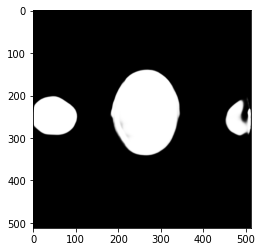

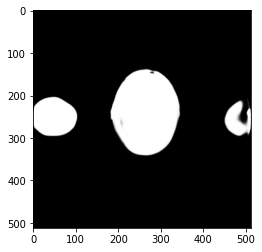

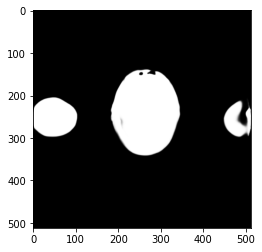

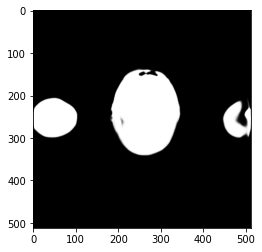

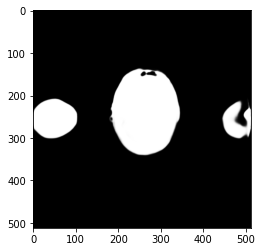

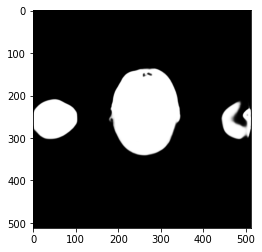

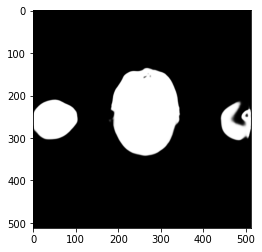

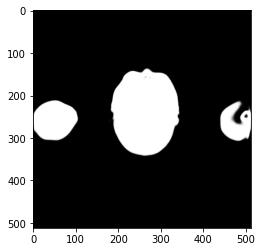

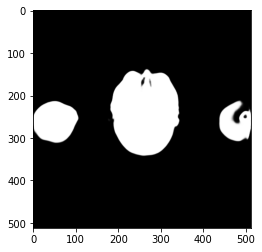

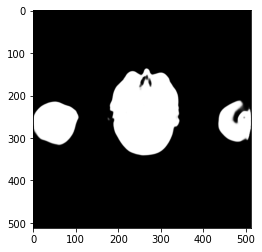

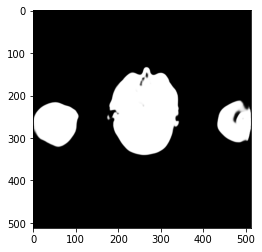

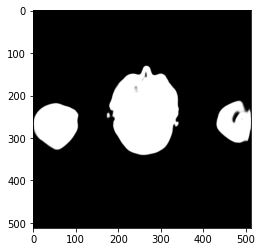

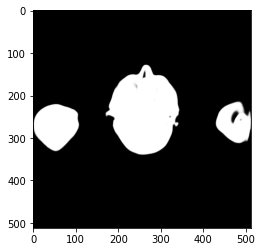

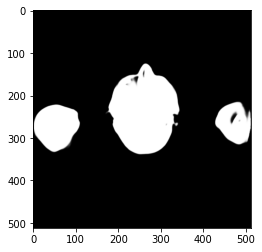

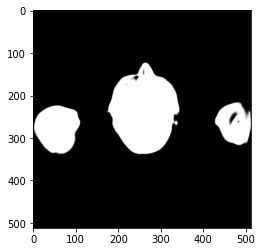

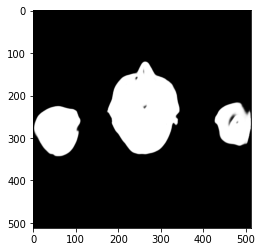

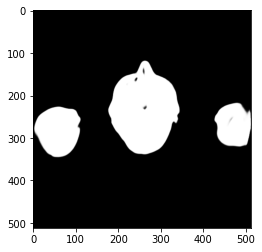

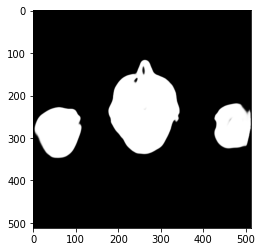

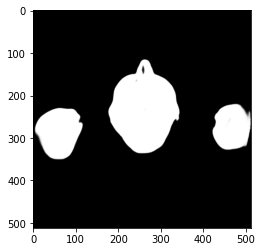

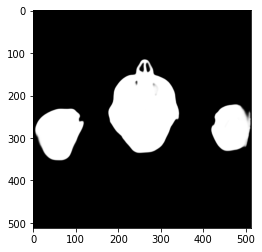

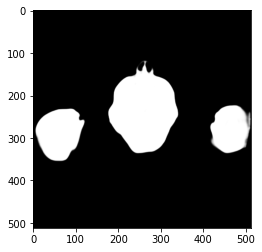

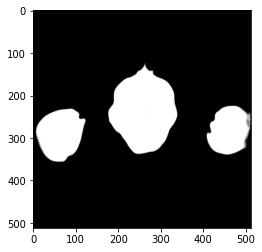

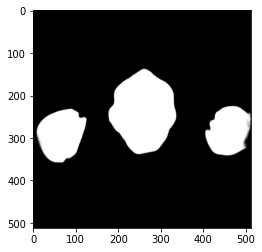

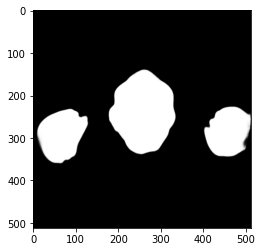

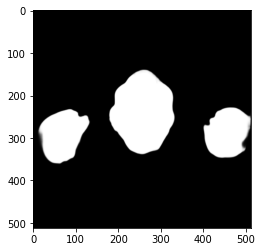

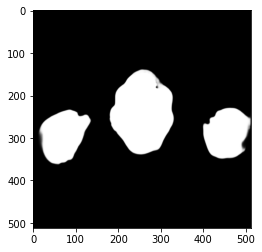

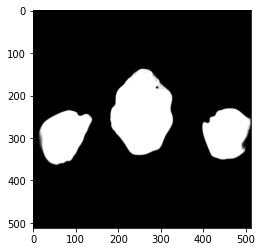

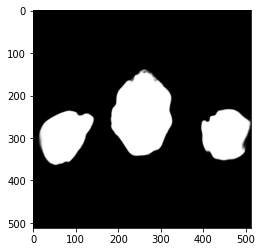

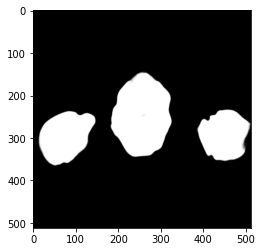

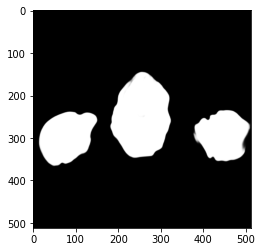

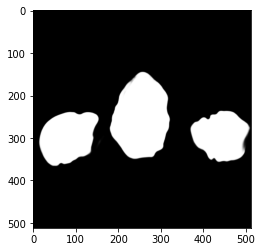

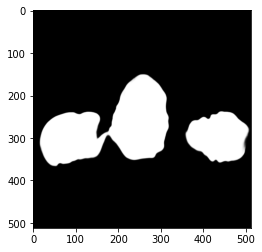

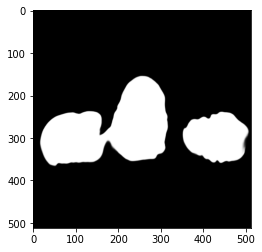

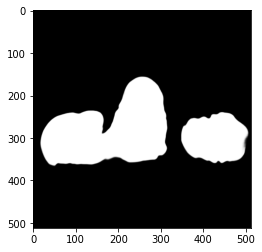

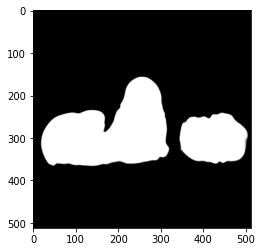

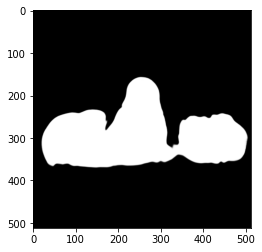

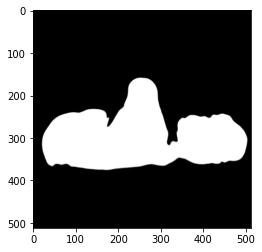

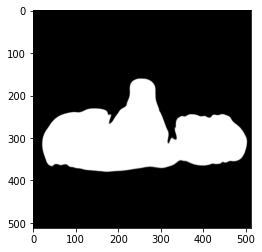

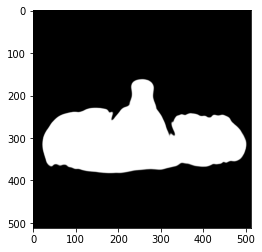

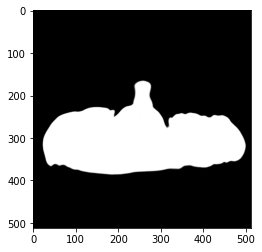

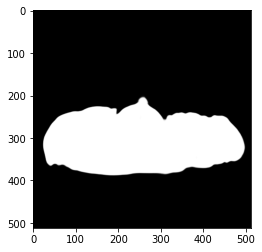

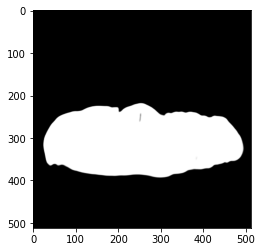

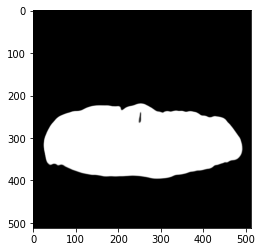

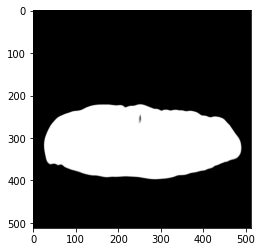

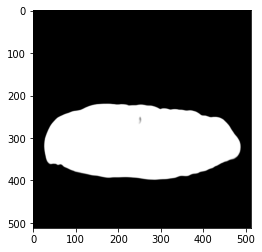

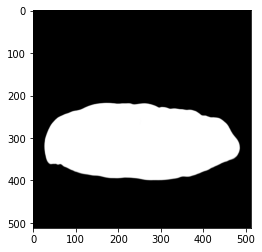

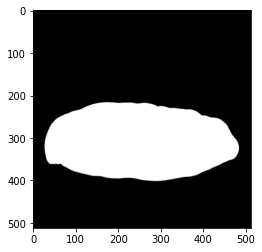

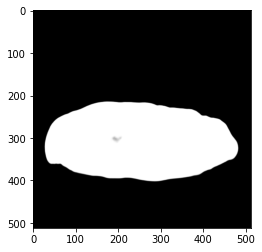

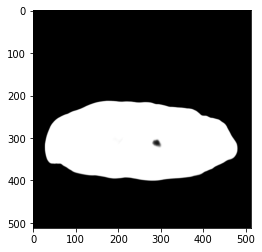

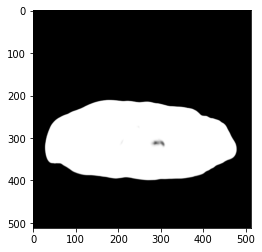

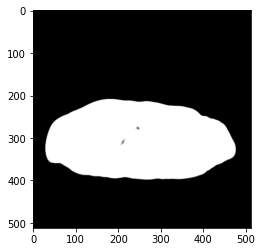

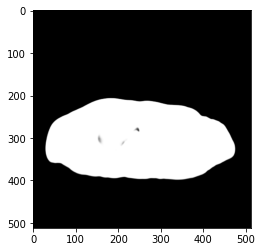

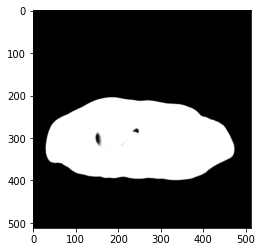

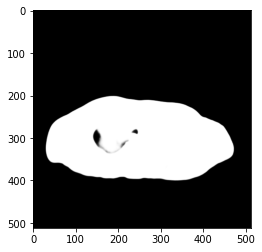

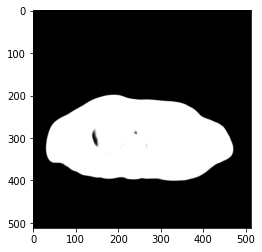

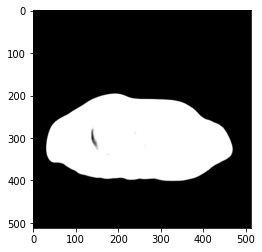

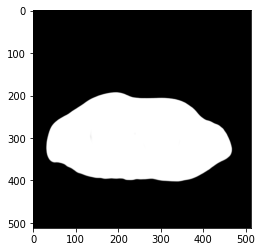

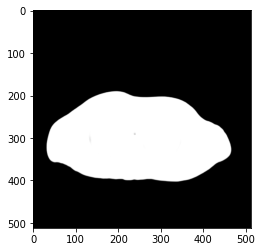

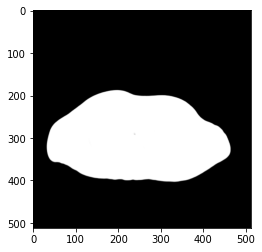

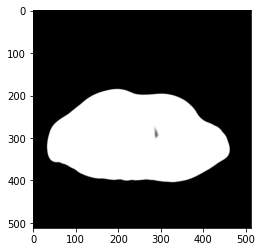

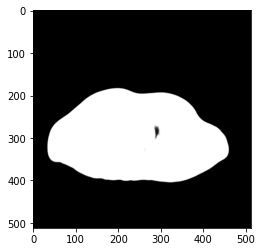

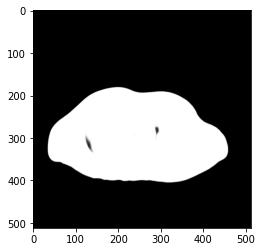

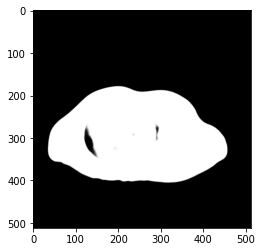

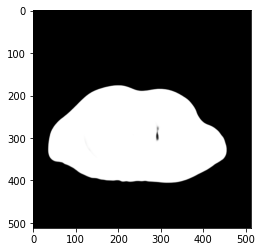

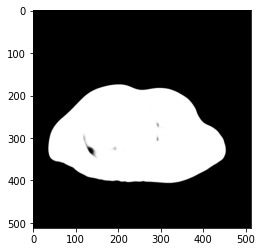

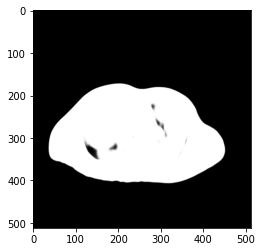

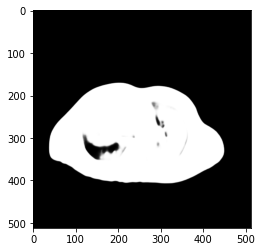

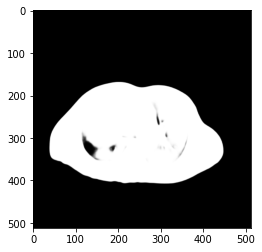

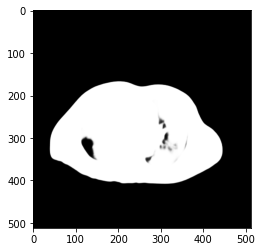

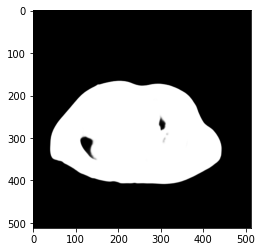

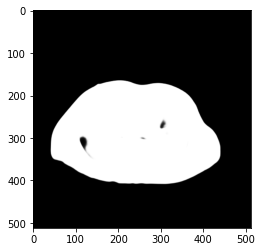

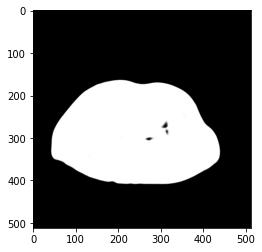

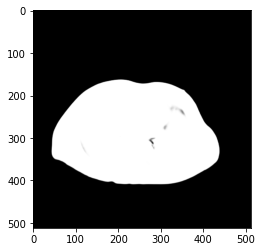

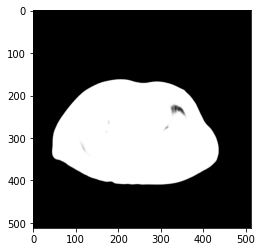

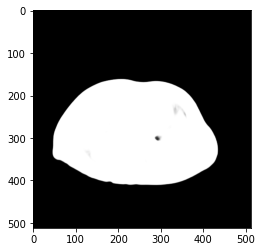

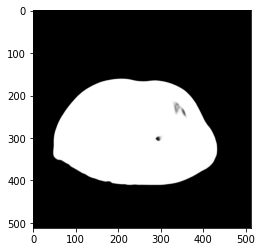

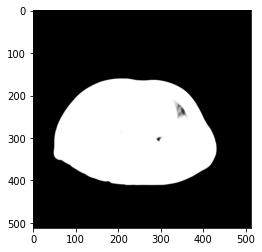

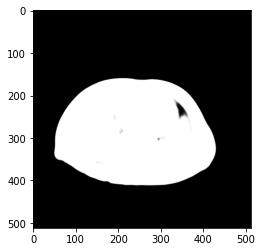

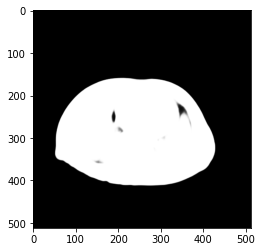

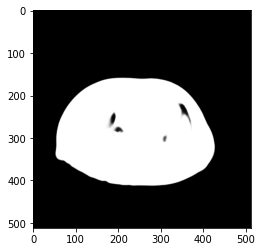

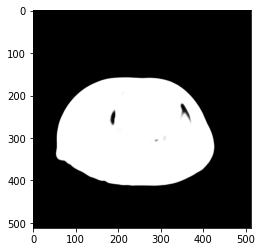

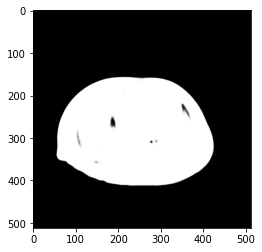

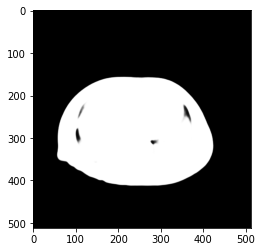

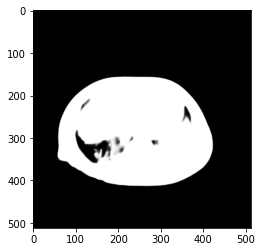

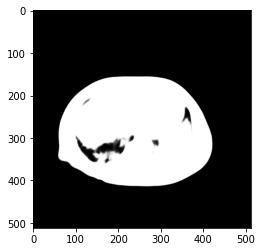

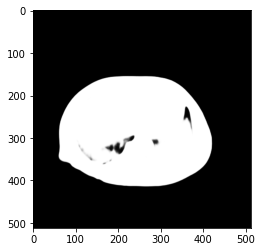

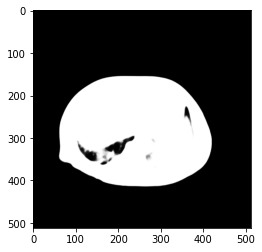

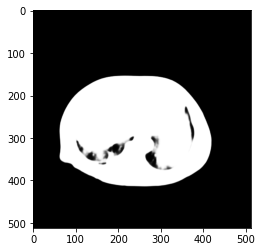

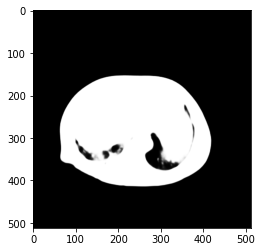

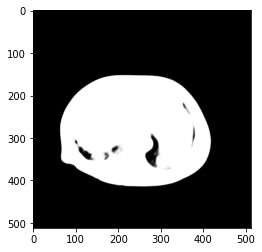

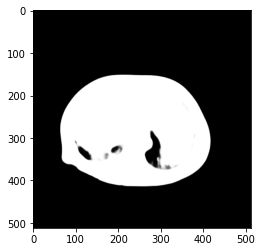

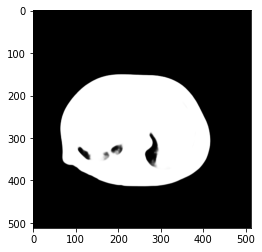

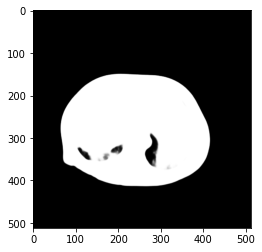

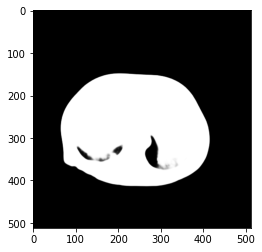

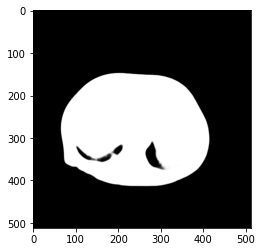

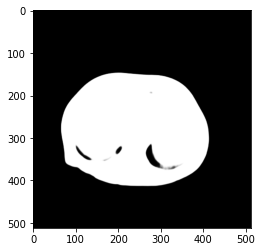

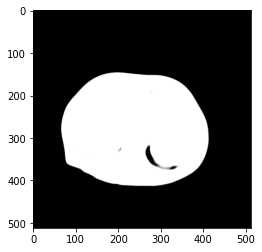

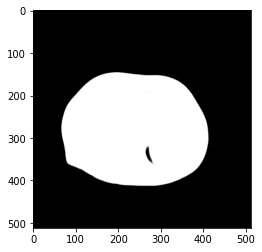

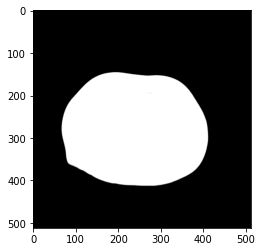

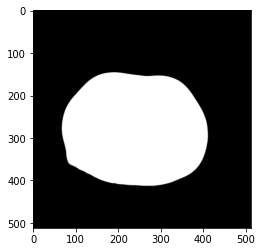

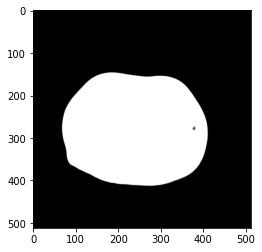

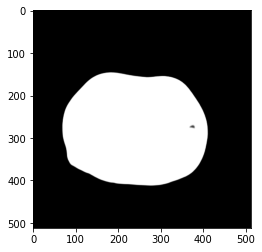

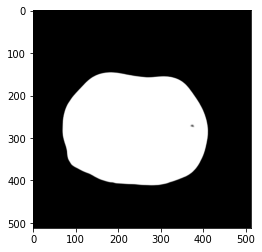

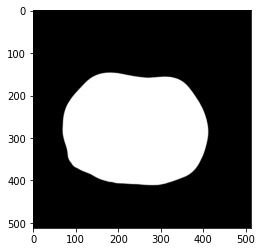

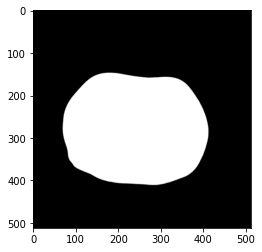

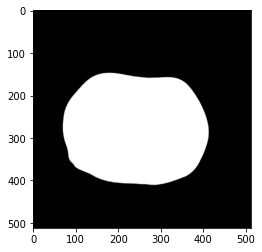

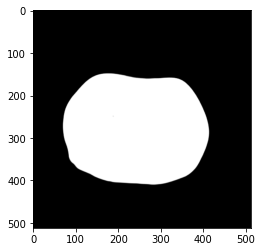

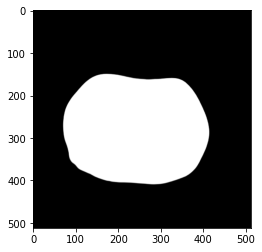

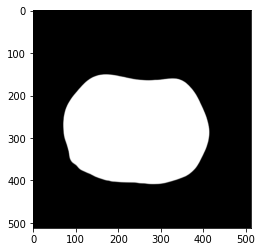

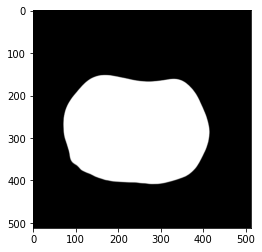

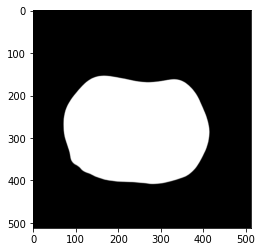

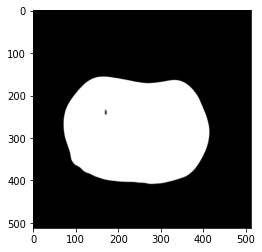

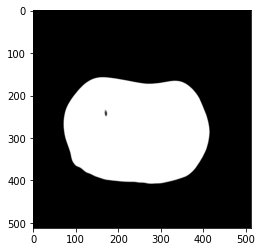

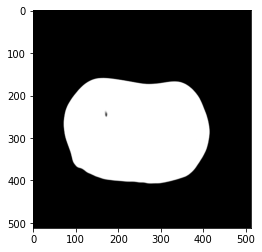

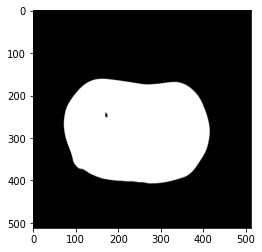

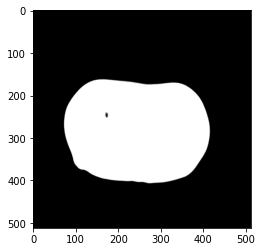

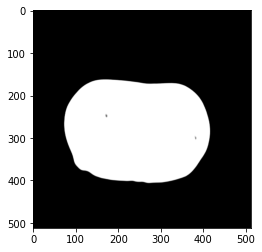

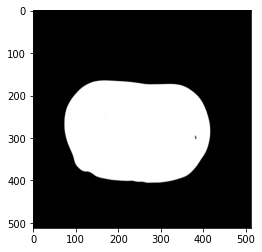

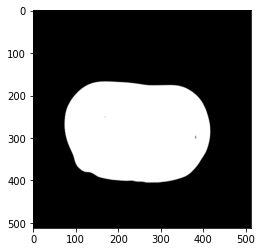

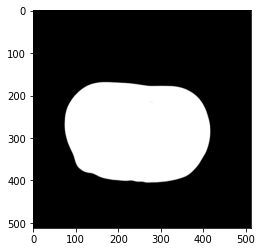

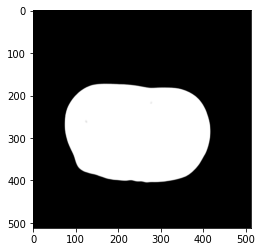

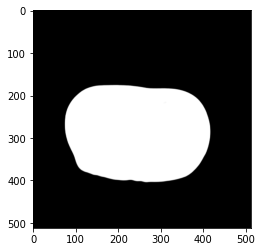

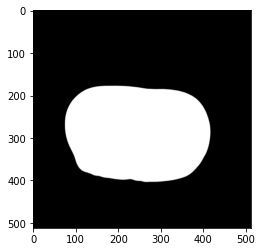

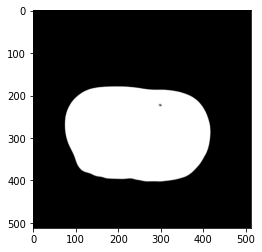

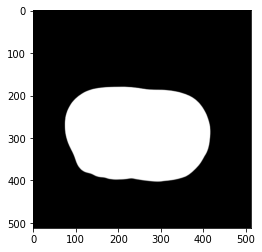

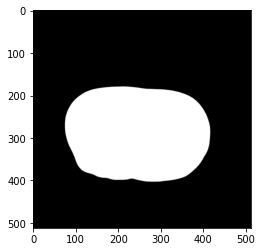

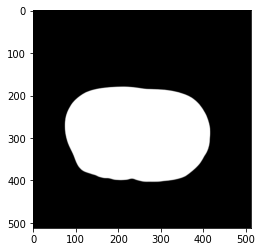

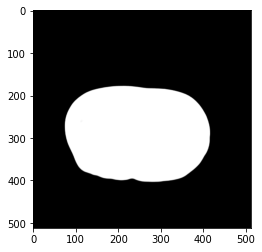

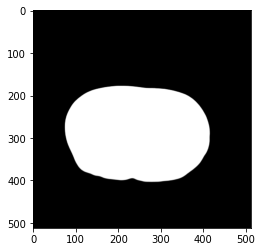

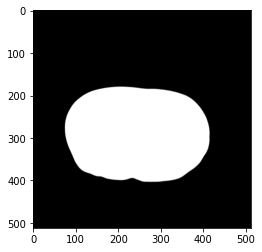

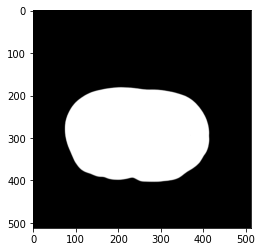

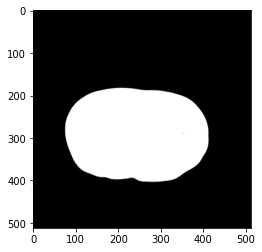

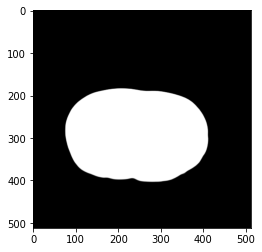

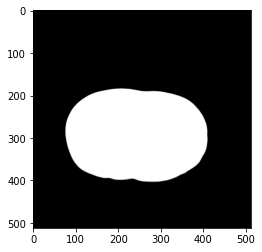

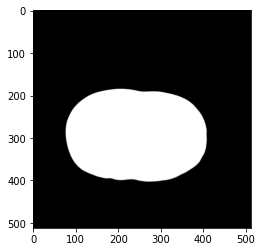

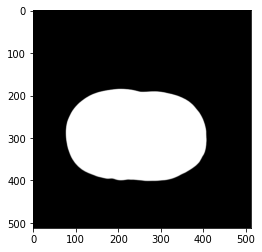

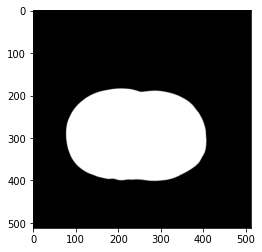

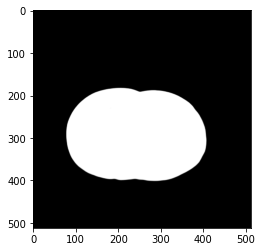

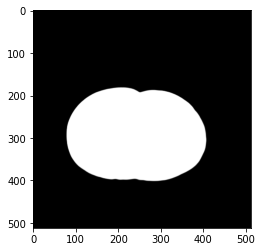

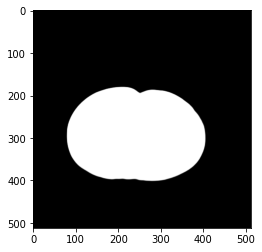

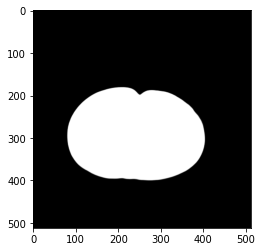

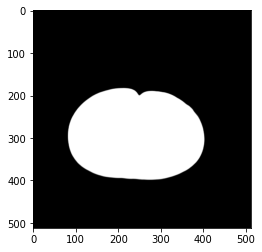

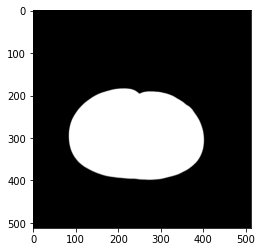

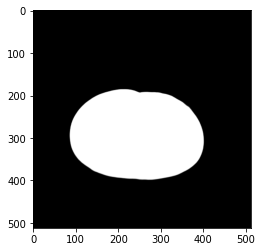

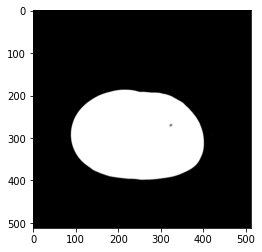

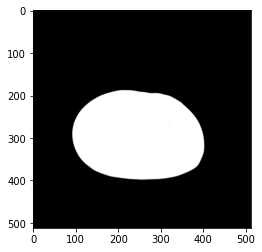

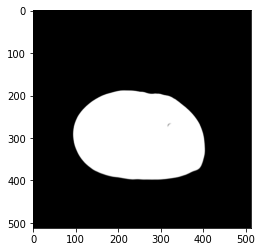

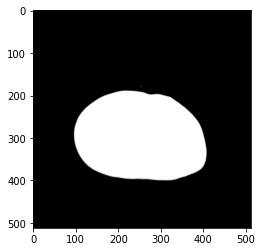

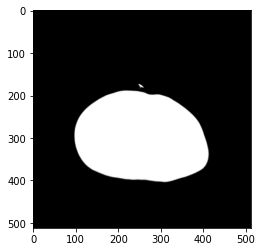

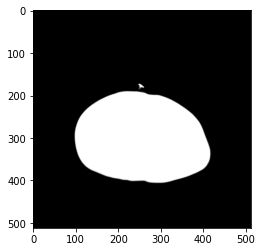

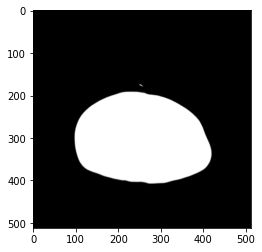

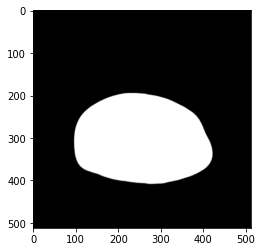

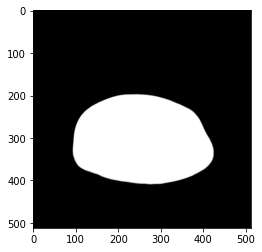

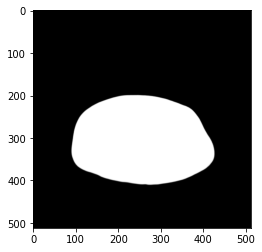

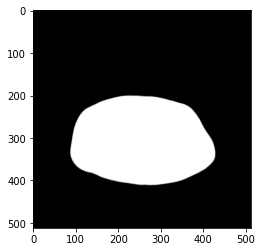

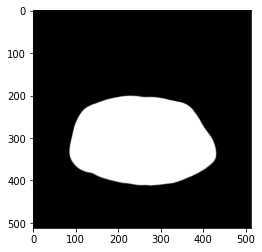

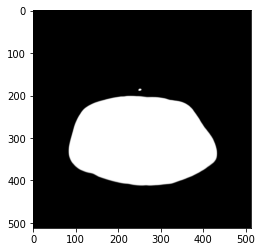

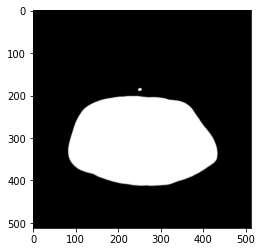

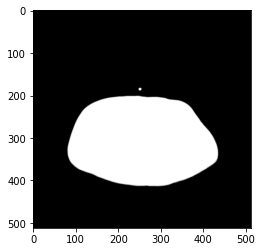

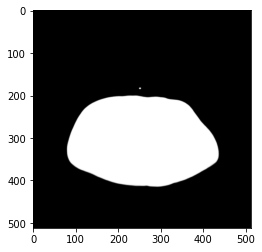

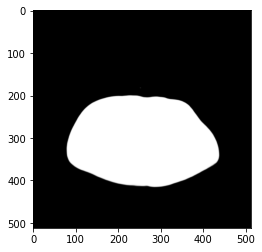

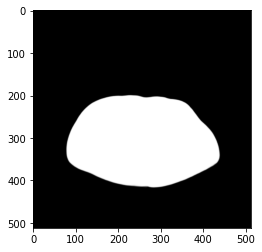

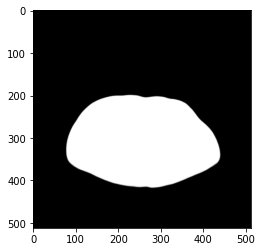

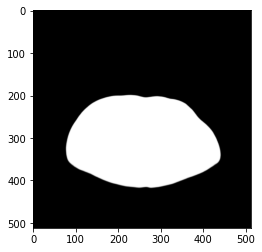

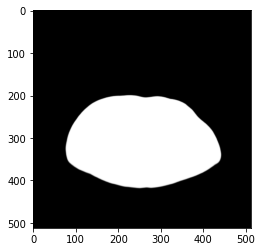

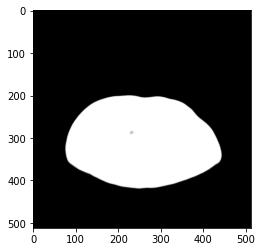

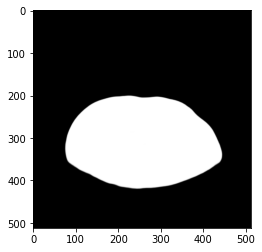

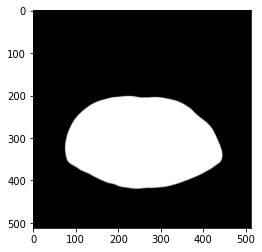

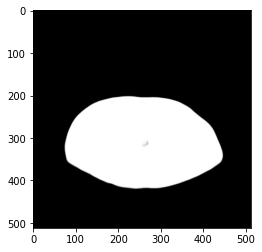

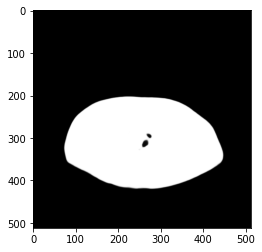

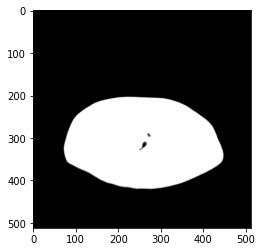

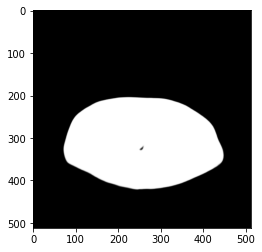

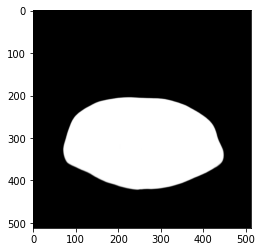

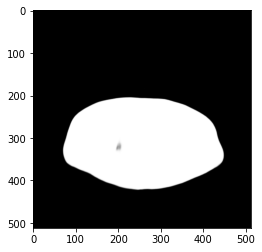

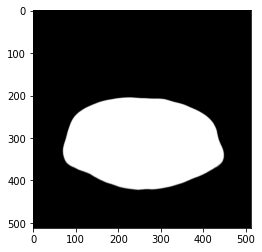

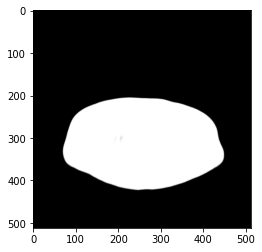

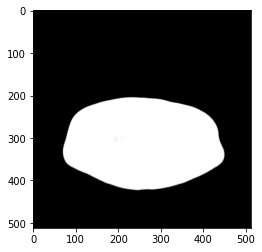

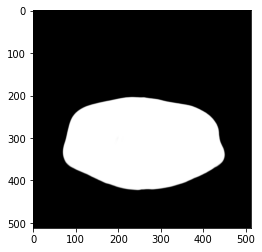

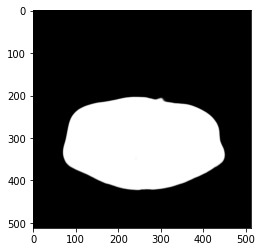

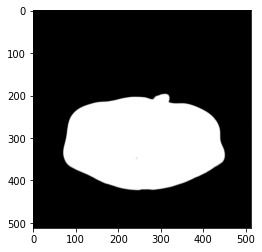

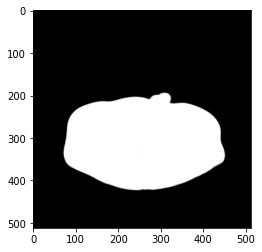

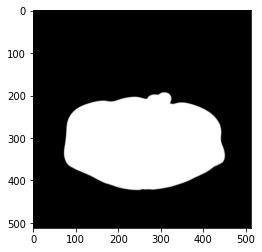

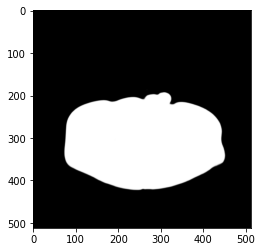

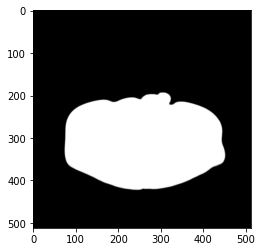

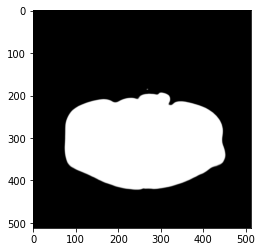

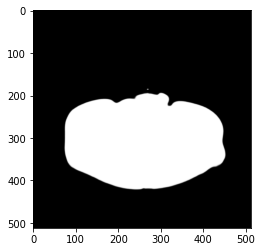

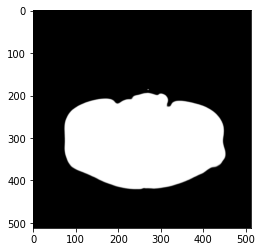

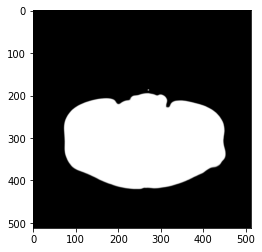

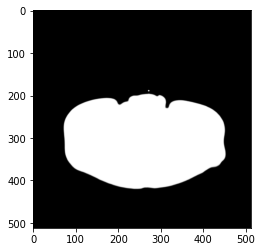

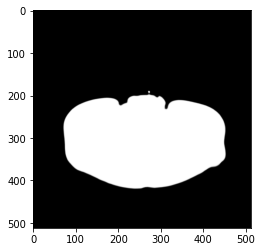

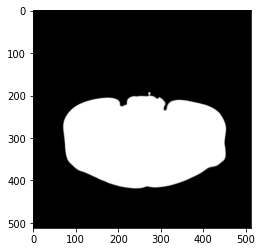

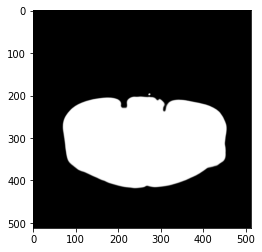

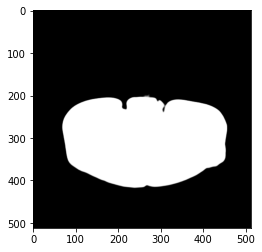

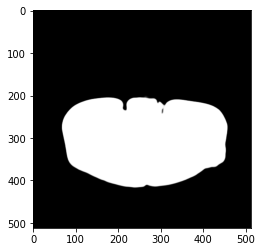

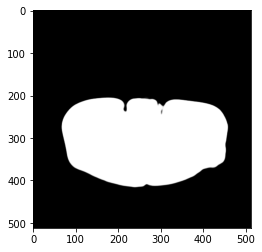

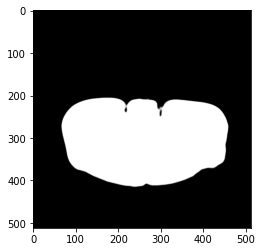

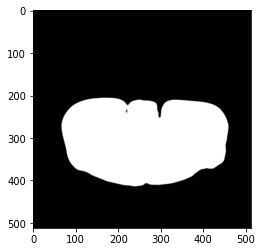

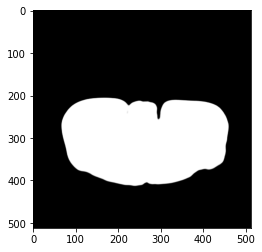

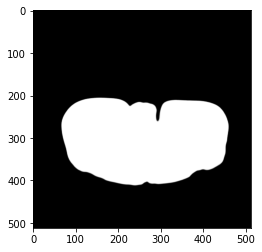

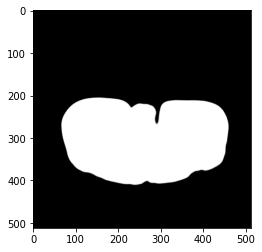

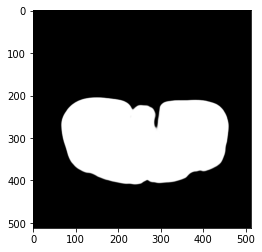

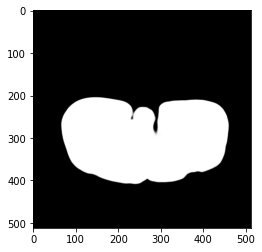

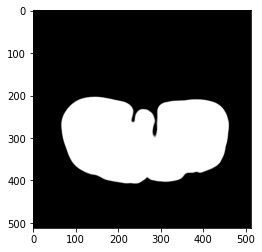

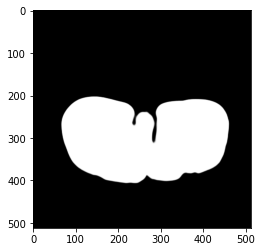

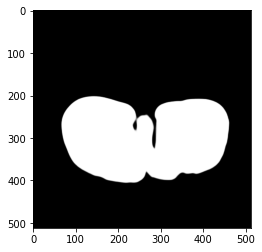

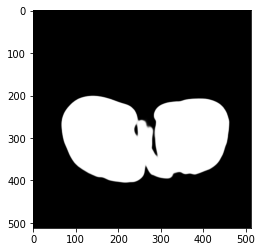

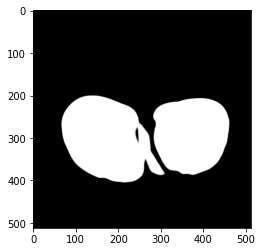

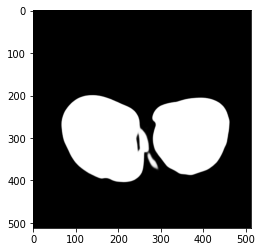

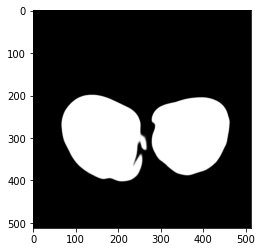

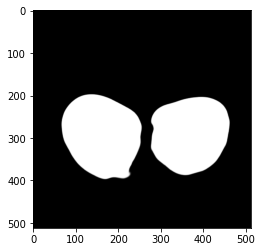

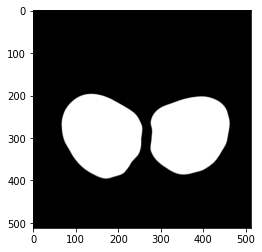

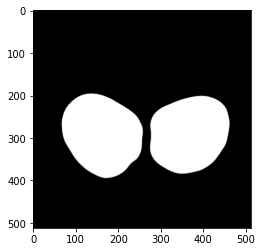

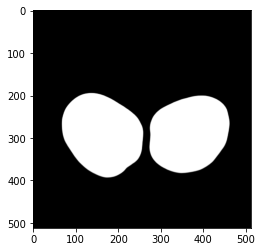

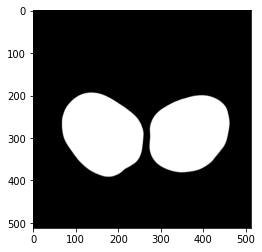

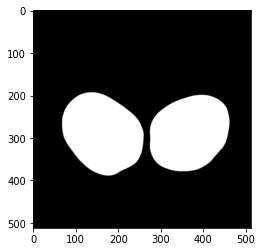

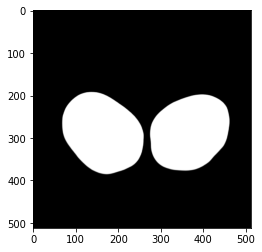

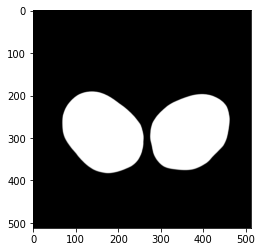

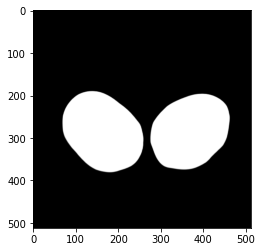

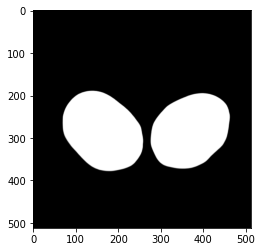

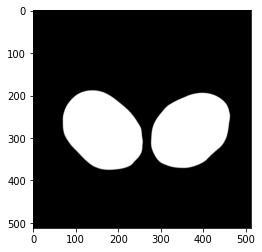

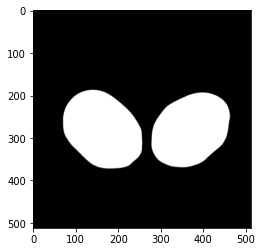

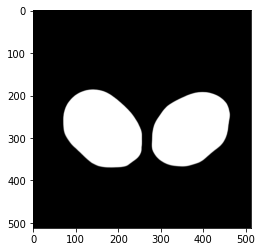

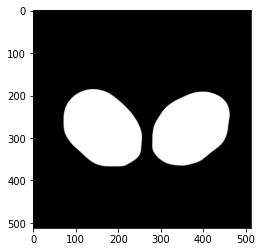

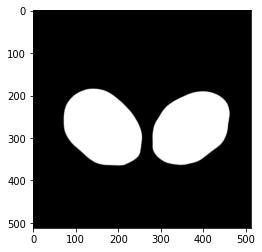

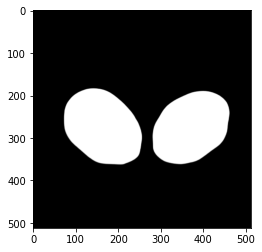

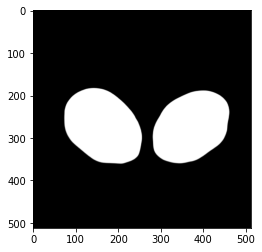

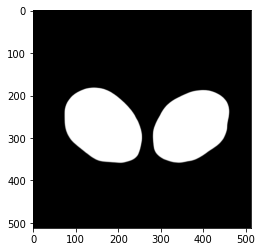

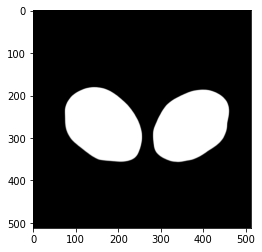

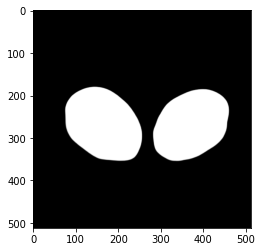

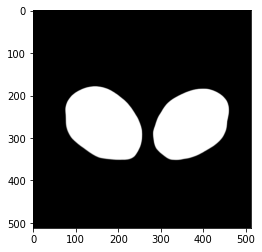

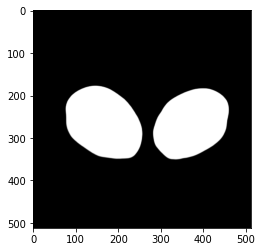

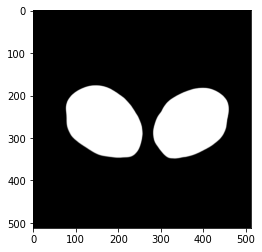

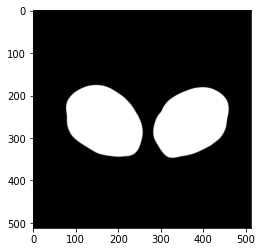

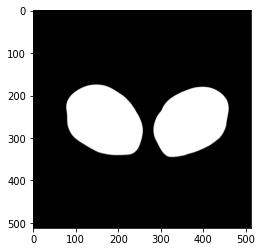

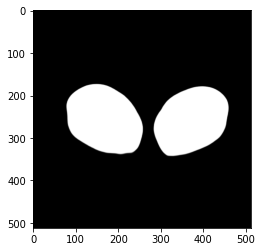

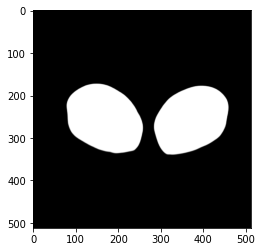

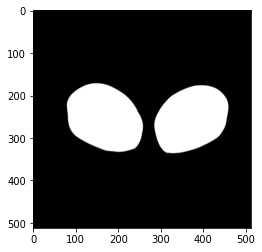

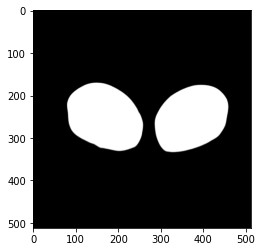

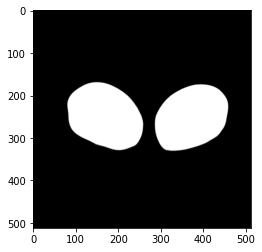

In [ ]:
for elem in plt_imgs:
    plt.imshow(elem, cmap='gray')
    plt.show()
    plt.close()